## Maximum Likelihood Estimation for a Stochastic Channel Model

In this notebook, we apply maximum likelihood estimation for 1-dimensional point processes in a signal-processing context. We investigate the [Turin model](https://ieeexplore.ieee.org/document/1093888/) based on an inhomogeneous Poisson point process of arriving signals.

As we will see, this is an intriguing question even for simulated data. After the simulation part, we analyze wideband signal data from indoor channels measured in [Wei's lab](https://link.springer.com/article/10.1186/s13638-016-0548-x).

## Signal Propagation

In wireless communication, a signal $x(t)$ sent out from a transmitter is subject to a variety of physical distortions. For instance, a signal does not only travel to its destination along a direct connection, but may be reflected and diffracted several times. This gives rise to **multi-path fading**.


Each of the different connection paths induces a **delay** by a time $\tau$ and the signal strength is determined by a **path-gain factor** $\alpha_\tau \in \mathbb C$. Here the path gains are complex, since in addition to the attenuation, they also induce a phase shift.
Hence, the receiver picks up a superposed signal described by the **channel equation**
$$Y(t) = \sum_{\tau \in Z} \alpha_\tau x(t-\tau) + W(t),$$
where $Z$ denotes the set of delays  associated with paths of substantial contribution to the received signal and $W(t)$ is thermal white noise. Introducing the **impulse response function** 
$$h =\sum_{\tau \in Z} \alpha_\tau \delta_\tau$$
as a characteristic of the underlying channel, the channel equation can be expressed via a convolution as  
$$Y(t) = (h * x)(t) + W(t).$$

## Stochastic Channel Model

In order to derive a specific stochastic model from the general channel equation, we need to specify the delays $Z$ together with the associated path gains $\alpha_\tau$, $\tau \in Z$. Mathematically speaking, we can think of the combined quantity $\{(\tau, \alpha_\tau)\}_{\tau \in Z}$ as a **$\mathbb C$-marked point process**. That is, a random point pattern on the time axis augmented by the corresponding path gains. 

In the [Turin model](https://ieeexplore.ieee.org/document/1093888/), $Z$ is an independently marked Poisson point process in a bounded window $I = [\tau_0, \tau_0 +|I|]$. In the simplest case, we could choose it to be homogeneous over the entire observation window. 
However, for indoor environments the simple Turin model is inappropriate and [it has been suggested](https://arxiv.org/abs/1809.03749) to use an inhomogeneous intensity of the form
$$\lambda(\tau) = \exp(\kappa_0) \tau^{\kappa_1} = \exp(\kappa_0 + \kappa_1 \log\tau)$$

The intensity $\lambda(\tau)$ and the path gain $\alpha_\tau$ are related to the central power delay spectrum $P_h(\tau)$ through 
$$P_h(\tau) = \lambda(\tau) \mathbb E\big[|\alpha_\tau|^2 \,\big|\, \tau\big].$$
For in-room environments, $P_h(t)$ [decays exponentially in $t$](https://ieeexplore.ieee.org/document/8605362/), in the sense that 
$$P_h(t) = G_0 \exp(-t / T),$$
where $G_0$ and $T$ denote the [gain factor and reverberation time](https://ieeexplore.ieee.org/document/7087370), respectively.

Solving for $\mathbb E\big[|\alpha_\tau|^2 \,\big|\, \tau\big]$ and absorbing $\kappa_0$ in a new parameter $\gamma_0$, we arrive at

$$\mathbb E\big[|\alpha_\tau|^2\, \big|\, \tau\big] = \exp\big(\gamma_0 + \gamma_1 \tau - \kappa_1\log(\tau)\big).$$

The modulus of the path gain follow a [Rayleigh distribution](https://en.wikipedia.org/wiki/Rayleigh_distribution) with exponentially decaying parameter $s_\tau$ in the delay. That is, the probability density of $|\alpha_\tau|$ equals
$$f(|\alpha_\tau|) = \frac{|\alpha_\tau|}{s_\tau^2}\exp\Big(-\frac{|\alpha_\tau|^2}{2 s_\tau^2}\Big),$$
where 
$$s_\tau = \frac1{\sqrt2} \exp(0.5 \cdot (\gamma_0 + \gamma_1 \tau - \kappa_1\log(\tau))),$$
so that $\alpha_0 = \exp(\gamma_0) \in \mathbb{R}$ denotes the path gain for $\tau = 0$. The parameter $\gamma_1 > 0$ describes the exponential decay of the signal strengths when travelling along a path with delay $\tau$.

In [1]:
rm(list=ls())

ray_param <- function(tau, theta){
        #' Extract Rayleigh parameter from $\g$-$\k$ vector
        #'
        #' @param tau delay
        #' @param theta parameter vector    
        exp(0.5 * (theta$gamma0 + theta$gamma1 * tau - theta$kappa1 * log(tau))) / sqrt(2)
}

Since measuring the impulse response function directly for a physical channel is difficult, it is more convenient to pass to the frequency domain. After Fourier transformation, the convolution becomes a multiplication, so that the channel equation in the frequency domain reads 
$$\tilde Y(f) =  \tilde h(f) \tilde x(f) + \tilde W(f),$$
where 
$$\tilde{h}(f) = \sum_{\tau \in Z} \alpha_\tau \exp(-2 \pi i f\tau)$$ 
is the **channel transfer function** and $\tilde W(f)$ is again white noise. 

In [2]:
h_freq <- function(latent){
    #' channel transfer function
    #'
    #' @param latent structure
    if(length(latent$taus) == 1)
        return(exp(freqs  * (latent$taus)) * latent$alphas)
    exp(tcrossprod(freqs, latent$taus)) %*% diag(latent$alphas)
}

By probing the channel with purely sinusoidal signals corresponding to a single frequency, we obtain independent training data $({\boldsymbol f, \boldsymbol y}) = \{(f_i, \tilde y_i)\}_{i \le n}$, where 
$$\tilde y_i =  \tilde h(f_i) + \tilde W_i,$$
and the $\{\tilde W_i\}_{i \le n}$ are iid complex Gaussian $N\mathbb{C}(0, \sigma^2)$.

In the following, a **point** is a pair $(\tau, \alpha_\tau)$ consisting of a delay $\tau$ and an associated path gain $\alpha_\tau$. We think of the points as a **latent structure** that cannot be observed directly in the measurements.

For any further work, need a function to generate new points and a function to compute the expected number of points in a window.

In [3]:
rpoint <- function(theta){
        #' Generate random marked points with exponentially decreasing marks
        #'
        #' @param theta parameter vector
    
        tau0 <- theta$tau0
        tau1 <- tau0 + theta$win_size
        k1 <- theta$kappa1 + 1
    
        taus <- tau0 * (runif(1) * ((tau1/tau0) ** k1 - 1) +  1) ** (1/k1) 
    
        alphas <- rrayleigh(1, ray_param(taus, theta))
        alphas <- alphas * exp(2 * pi * 1i * runif(1))
    
        data.frame(taus=taus, alphas=alphas)
}

In [4]:
exp_points <- function(theta){
    #' Compute expected number of points in window
    #'
    #' @param theta parameter vector
    k1 <- (theta$kappa1 + 1)
    t0 <- theta$tau0
    exp(theta$kappa0) * ((theta$win_size + t0) ** k1 -  t0 ** k1) / k1
}

## Maximum Likelihood Estimation

We fit the channel model to data via maximum likelihood estimation (MLE). More precisely, the goal of MLE is to maximize the likelihood after marginalizing over the delays, i.e., to solve
$$\max_\theta\ell(\boldsymbol y; \theta) =\max_\theta c_\theta = \max_\theta\int L(\boldsymbol y, z; \theta){\rm d}z.$$



Here, we face the problem of approximating a **missing-data log-likelihood**. Although $L(\boldsymbol y, z; \theta)$ is available in closed form, after marginalizing the point process, the optimization problem is no longer analytically tractable.

However, we can tackle this issue by fixing a base parameter vector $\theta_0$ and then maximizing instead the ratio $c_\theta/c_{\theta_0}$. More precisely, as shown in Equation (8.11) of [Statistical inference and simulation for spatial point processes](https://mathscinet.ams.org/mathscinet/pdfprint/2004226.pdf), 
\begin{align*}
\frac{c_\theta}{c_{\theta_0}} = \frac{\int L(\boldsymbol y, z; \theta){\rm d}z}{\int L(\boldsymbol y, z'; \theta_0){\rm d}z'} = \int\frac{L(\boldsymbol y, z; \theta)}{L(\boldsymbol y, z; \theta_0)}\frac{L(\boldsymbol y, z; \theta_0)}{\int L(\boldsymbol y, z'; \theta_0) {\rm d} z'} {\rm d} z = \mathbb E_{Z|\boldsymbol y;\theta_0}\Big[\frac{L(\boldsymbol y, Z; \theta)}{L(\boldsymbol y, Z; \theta_0)}\Big],
\end{align*}

where $\mathbb E_{Z|\boldsymbol y;\theta_0}$ denotes the conditional expectation of the latent structure $Z$ given the data $\boldsymbol y$  under the parameter $\theta_0$. Given samples $\{Z_i\}_{i \le N}$ from the conditional distribution, and considering $w_i = L(\boldsymbol y, Z_i; \theta)/L(\boldsymbol y, Z_i; \theta_0)$ as weight, we then rely on the estimator
$$\frac{c_\theta}{c_{\theta_0}} \approx \frac 1N \sum_{i \le N} w_i.$$

## Conditional Simulation

 Drawing from the conditional distribution of the point process $Z$ given the data is a difficult task. First, the delays $Z$ enter the log-likelihood via the complicated channel transfer function $\tilde h$, so that a closed-form description of its conditional distribution is out of reach. Hence, we need to approximate the objective $c_\theta/c_{\theta_0}$ by samples from an expensive birth-death MCMC, as described in Chapter 8 of [Statistical inference and simulation for spatial point processes](https://mathscinet.ams.org/mathscinet/pdfprint/2004226.pdf).

The MCMC sampling in channel models is characterized by meta-stability. Once the sampler finds delays that approximately match the points from the latent structures, it becomes extremely challenging to remove the points, as this would reduce the log-likelihood massively. In order to tackle this problem, we rely on parallel tempering and the option of mark changes.

### Parallel Tempering

[Parallel tempering](http://www.stat.umn.edu/geyer/f05/8931/c.pdf) reduces the autocorrelation of slowly-mixing Markov chains samplers by running in parallel several variants of the chain that mix substantially faster. Occasionally, the faster chains swap states with the slower ones, thereby reducing the mixing time of the slower chains.

For the stochastic channel model, we can construct faster chains by increasing the variance $\sigma^2$ of the thermal noise. Indeed, for large-noise scenarios the peaks at the delays are less pronounced, so that the chain can escape local minima.

The swaps between different chains are based on a Metropolis-Hastings criterion. More precisely, a chain in state $\boldsymbol Z$ with parameters $\theta$ swaps states with a chain in states $\boldsymbol Z'$ with parameters $\theta'$ with probability
$$1 \wedge \frac{\exp(\ell\big(\boldsymbol y, \boldsymbol Z; \theta') + \ell(\boldsymbol y, \boldsymbol Z'; \theta)\big)}
{\exp\big(\ell(\boldsymbol y, \boldsymbol Z; \theta) + \ell(\boldsymbol y, \boldsymbol Z'; \theta')\big)}.$$

On a technical level, we store not only the delays and marks but also the associated components of the channel transfer. Although they can be recovered from the latent structure, repeating the entire computation in each step of the MH sampler would be prohibitively expensive.

Furthermore, storing realizations and the parallelization from the tempering incur substantial overhead, so that we only retain the states after the temperature swaps and not within the MH steps. Hence, we perform a thinning and only retain every 200th realization.

### Birth/Death MCMC

In [5]:
mcmc_pt <- function(loglik_unmarked,
                        latent_init,
                        thetas, 
                        niter = 4e5, 
                        verbose = -1,
                        mh_steps = 2e2
                    ){
    #' MCMC via parallel tempering
    #'
    #' Simulates the distribution of the latent structure conditioned on the data
    #' @param loglik_unmarked log-likelihood for an unmarked point configuration
    #' @param latent_init initial latent structure
    #' @param thetas list of parameters, one for each temperature level
    #' @param niter number of iterations
    #' @param verbose interval for printing logs
    #' @param mh_steps number of Metropolis steps between temperature swaps

    time <- 0
    
    #rescale niter, verbose and burn-in
    niter <- niter / mh_steps
    verbose <- verbose / mh_steps

    #number of temperatures
    ntemps <- length(thetas)
    temps <- 1:ntemps
    
    #track acceptance rate for temperature swaps
    acc_rate <- rep(0, ntemps - 1)     

    #compute channel transfer for initial latent
    ct_comp_curs <- lapply(temps, function(i) t(h_freq(latent_init)))
    ct_curs <- lapply(ct_comp_curs, function(hcc) rowSums(t(hcc)))  

    #initialize latent, channel transfer, loglikelihood  and channel transfer components
    curs <- lapply(temps, function(i)
                    list(latent_init,
                         ct_curs[[i]],
                         loglik_unmarked(latent_init, thetas[[i]], ct_curs[[i]]),
                         ct_comp_curs[[i]]
                    )
            )  
                      
    #initialize result data frame
    list_size <- niter + 1
    result_df <-  data.frame(latent = rep(0, list_size), 
                      ct = rep(0, list_size))
    result_df[1,] <- lapply(1:2, 
                                 function(j) list(curs[[1]][[j]])
                            )
                           
    # initialize lists for latent and channel transfers                            
    latent_lists <- lapply(temps, 
                          function(i) vector(mode = "list", 
                                             length = list_size)
                          )
    ct_lists <- lapply(temps, 
                          function(i) vector(mode="list", 
                                             length = list_size)
                          )                   
    #initialize result data frame
    for(i in temps){      
        latent_lists[[i]][[1]] <- curs[[i]][[1]]
        ct_lists[[i]][[1]] <- curs[[i]][[2]]
    }

    #MCMC loop    
    for(iter in 1:niter){

        #Metropolis moves
        curs <- mclapply(temps, function(i)
                       mcmc(loglik_unmarked,
                            curs[[i]],
                            thetas[[i]], 
                            mh_steps),
                         mc.cores = 10)
        
        #convert into dataframe to compute logliks
        latct_result_df <- result_df[1,]
        for(i in temps)
            latct_result_df[i,] <- lapply(1:2, function(j) list(curs[[i]][[j]]))

        #temperature swaps  
        for(i in temps[-1]){
            mixed <- log_joint(latct_result_df[i - 1,], thetas[[i]]) + 
                    log_joint(latct_result_df[i,], thetas[[i - 1]])

            true <- log_joint(latct_result_df[i,], thetas[[i]]) + 
                    log_joint(latct_result_df[i - 1,], thetas[[i - 1]])

            if(log(runif(1)) < mixed - true){
                acc_rate[i - 1] <- acc_rate[i - 1] + 1
                curs[c(i - 1, i)] <- curs[c(i, i - 1)]
                latct_result_df[c(i - 1, i),] <- latct_result_df[c(i, i - 1),]
            }
        }

        #store realization    
        for(i in temps){
            latent_lists[[i]][[iter + 1]] <- curs[[i]][[1]]
            ct_lists[[i]][[iter + 1]] <- curs[[i]][[2]]
        }
                                              
        #print diagnostics
        if(iter %% verbose  == 0){
            print(Sys.time() - time)
            print(acc_rate/iter)
            
            result_df[1,] <- list(list(curs[[1]][[1]]), list(curs[[1]][[2]]))
            time <- Sys.time()
            
            x <- sprintf("%1$d: %2$5.0f %3$d",
                         iter,
                         log_joint(result_df[1,], thetas[[1]]),
                         dim(result_df[1,]$latent[[1]])[1])
            message(x)
        }
    }    

    #fill result data frame and return                                          
    result_df$latent <- latent_lists[[1]]
    result_df$ct <- ct_lists[[1]]
    result_df[-1, ]
}

In essence, between the state swaps of the tempering, we build on a birth-death Metropolis-Hastings sampler, as described in Chapter 8 of [Statistical inference and simulation for spatial point processes](https://mathscinet.ams.org/mathscinet/pdfprint/2004226.pdf). For the birth proposal, we add a point uniformly at random in the sampling window.  For a death proposal, we remove a point at random.

 In addition to the standard birth and death steps, it is critical to allow for the possibility to only change the mark but not the location of a point. This is particularly useful in the present setting due to the following reason. If the MCMC gives birth to a point close to the true location of a strong delay, this provides a substantial boost to the likelihood, even if the mark is not entirely correct. Such points are unlikely to die in a future death move, as this would lead to a too sharp drop of the likelihood.

Without the option of changing marks, it is only possible to correct for a misplaced mark by giving birth to further points at the considered location. When fitting to data, we observed that this tricked the MCMC into creating too many points.

We also note that in the MCMC below, we generate the Rayleigh marks via the inversion method. Then, the mark density is constant and it suffices to consider likelihoods of the unmarked point process.

Since the MCMC runs in total 400,000 steps, we inline all functions in order to avoid copying costs. Unfortunately, this leads to a lengthy method.

In [6]:
mcmc <- function(loglik_unmarked,
                        latent_list,
                        theta,
                        niter,
                        p_move = .6,
                        p_pos = .1,
                        p_phase = .5,
                        p_birth = .5,
                        sd_shift = .25,
                        sd_phase = 5,
                        sd_mod = .5
                ){
    #' MCMC via Metropolis Hastings
    #'
    #' Simulates Markov chain converging to the posterior
    #' @param loglik_unmarked log-likelihood for an unmarked point configuration
    #' @param latent_list list containing latent, channel transfer, loglikelihood  
    #'                    and channel transfer components
    #' @param theta parameter vector for MCMC
    #' @param niter number of iterations
    #' @param p_move probability of move proposal
    #' @param p_pos probability of position-change proposal conditioned on move proposal
    #' @param p_phase probability of phase-change proposal conditioned on move proposal
    #' @param p_birth probability of birth proposal conditioned on non-move proposal
    #' @param sd_shift standard deviation of proposal distribution for shifting points
    #' @param sd_phase standard deviation of proposal distribution for shifting complex argument
    #' @param sd_mod standard deviation of proposal distribution for shifting complex modulus

    #retrieve arguments
    latent_cur <- latent_list[[1]]
    ct_cur <- latent_list[[2]]
    loglik_cur <- latent_list[[3]]
    ct_comp_df_cur <- latent_list[[4]]
    
    #normalizing constant for birth/death move,
    norm <- (theta$tau0 + theta$win_size ) ** (theta$kappa1 + 1) - theta$tau0 ** (theta$kappa1 + 1) 
    norm <- norm / (theta$kappa1 + 1)
    for(iter in 1:niter){
        point_new <- NULL
        ct_new <- 0
        ct_old <- 0
        move <- F
        
        #propose mark change
        if(runif(1) < p_move){
            #select point at random
            move <- T
            idx <- sample(1:length(latent_cur$taus), 1)

            #make proposal
            point_old <- latent_cur[idx,]
            point_new <- point_old 

            #store channel transfer
            ct_old <- ct_comp_df_cur[idx,]
            ll_mod <- 0
            
            #phase change?
            phase_change <- F
            
            #change position
            if(runif(1) < p_pos){
                    shift <- sd_shift * rnorm(1)                    
                    point_new$taus <-  point_new$taus + shift
                                                    
                    #update channel transfer
                    ct_new <- ct_old * exp(freqs * shift)
                
                    #reject moves outside the window
                    if(point_new$taus < theta$tau0 || point_new$taus > theta$tau0 + theta$win_size)
                        ll_mod = -Inf                  
            }
            else{                
                #change argument
                if(runif(1) < p_phase){
                    phase_change <- T
                    point_new$alphas <- point_new$alphas * exp(sd_phase * 1i * rnorm(1))
                }

                #change modulus
                else{
                        shift_mod <- sd_mod * rnorm(1)
                        mod_prop <- Mod(point_new$alphas) * exp(shift_mod)
                        point_new$alphas <- mod_prop * exp(Arg(point_new$alphas) * 1i) 
                    
                        #adapt through Jacobian of log-normal
                        ll_mod = shift_mod
                    }

                #update channel transfer
                ct_new <- point_new$alphas / point_old$alphas *  ct_old
            }
            #compute current likelihood and update the latent structure
            la_prev <- log_rayleigh(latent_cur, theta)
            latent_cur[idx,] <- point_new  
            
            #adapt the ratios 
            if(ll_mod > -Inf && !phase_change)
                ll_mod <- ll_mod + log_rayleigh(latent_cur, theta) - la_prev                        
        }

        #propose either birth or death
        else{
            if(runif(1) < p_birth){
                #make proposal
                idx <- length(latent_cur$taus) + 1
                point_new <- rpoint(theta)                
                latent_cur[idx,] <- point_new

                #update channel transfer
                ct_new <- exp(freqs  * point_new$taus) * point_new$alphas

                #update loglikelihood
                ll_mod <- -log(point_new$taus) * theta$kappa1 + log(norm / dim(latent_cur)[1]) 
                ll_mod <- ll_mod + log((1 - p_birth) / p_birth)       
            }
            else{
                #choose a point uniformly at random
                idx <- sample(1:(length(latent_cur$taus)), 1)

                #store channel transfer
                ct_old <- ct_comp_df_cur[idx,]

                #update loglikelihood and store current latents
                ll_mod <- log(latent_cur[idx, ]$taus) * theta$kappa1 - log(norm / dim(latent_cur)[1]) 
                ll_mod <- ll_mod - log((1 - p_birth) / p_birth)

                latent_old <- latent_cur
                latent_cur <- latent_cur[-idx,]
            }
        }

        #update channel transfer and compute proposal likelihood
        ct_prop <- ct_cur + ct_new - ct_old
        loglik_prop <- loglik_unmarked(latent_cur, theta, ct_prop)
        log_rat <- loglik_prop + ll_mod - loglik_cur
        
        #check if proposal is accepted
        if((!anyNA(log_rat)) && (log(runif(1)) < log_rat)){
            
            #update channel transfer and loglik
            ct_cur <- ct_prop
            loglik_cur <- loglik_prop

            ###update channel transfer
            #death
            if(length(point_new) == 0)
                ct_comp_df_cur <- ct_comp_df_cur[-idx,]
            else{
                    #mark change
                    if(move)
                        ct_comp_df_cur[idx,] <- ct_new
                    #birth
                    else
                        ct_comp_df_cur <- rbind(ct_comp_df_cur, ct_new)
                }
            }
        ##restore latent
        else{
            #death
            if(length(point_new) == 0)
                latent_cur <- latent_old
            else{
                #mark change
                if(move)
                    latent_cur[idx,] <- point_old 
                #birth
                else
                    latent_cur <- latent_cur[-idx,]                                       
            }
        }       
    }                  
    list(latent_cur, ct_cur, loglik_cur, ct_comp_df_cur)
}

## Optimization

After estimating $c_\theta/c_{\theta_0}$ for a given $\theta$ via weights drawn from the MCMC sampler, the next step is to find an optimal parameter value $\theta$. 

### Cross-Entropy Method

First, we consider the [Cross-Entropy (CE) Method](https://www.sciencedirect.com/science/article/pii/B9780444538598000035) as a gradient-free approach. It is conceptually elegant, simple to implement and performs robustly on a variety of problems. 

For the present task, the CE method features distinguished advantages over the Newton-Raphson method. On the one hand, the Newton-Raphson algorithm is a powerful optimization method designed to leverage first- and second-order information in an optimal manner. If the objective function is well-behaved, these methods cannot attain the convergence speed of the Newton-Raphson algorithm and will require a substantially higher number of evaluations of the objective function. However, if the objective function is non-convex and features many local minima and maxima, then the second-order information is unreliable and the optmization quickly becomes instable. This is precisely the situation we are experiencing in our setting.

In the present setting, the computational bottleneck is clearly not the optimization algorithm but the MCMC sampler. Moreover, as the run-time of optimization algorithm is typically dominated by evaluations of functions at different parameter points, they benefit strongly from parallel computation.

At its heart, the CE method first generates $n$ samples and then selects the top $k$ performers as *elite* selection. Then, the proposal distribution is adapted to that selection. 

In [7]:
cem_optim <- function(obj_fun, 
                      theta_init, 
                      sd_init, 
                      precond,
                      nevals = 250,
                        elite_size = 10,
                        niter = 10,
                        param_cols = 1:5,
                        ll_ess_cols = 8:9,
                      min_ess = 400,
                      min_ll_diff = .1){
    #' Cross-entropy method
    #'
    #' @param obj_fun function that is to be optimized
    #' @param theta initial mean of the proposal distribution
    #' @param sd_init initial standard deviation of proposal distribution
    #' @param precond preconditioning matrix
    #' @param nevals number of points where function is evaluated
    #' @param elite_size size of the elite selection  
    #' @param niter number of iterations
    #' @param param_cols column indices containing the parameters to be updated
    #' @param ll_ess_cols column indices containing loglikelihood and effective sample size
    #' @param min_ess lower ess bound for admissible parameters
    #' @param min_ll stopping criterion in terms of loglik improvement
    
    mu <- theta_init
    mu[, param_cols] <- precond %*% t(mu[, param_cols])
    theta_init_trans <- mu
    sd <- sd_init
      
    ll_diff <- min_ll_diff + 1
    ll_old <- -Inf
    
    #continue searching for a maximum as long as there is 
    #substantial improvement
    while(ll_diff > min_ll_diff){
        
        #evaluate function
        vals <- cem_evals(obj_fun, mu, sd, precond, nevals)
        
        #select rows with highest rss
        ess <- vals$ess[rev(order(vals$ess))][5 * elite_size]
        
        #Generate CEM proposal parameter sample inside trust region
        while(ess < min_ess){
            #first find trust region
            vals <- cem_evals(obj_fun, mu, sd, precond, nevals)
            #select rows with highest rss
            nrows <- dim(vals)[1]
            elite <- vals[rev(order(vals$ess)),][1:min(nrows, elite_size), ]  
            ess <- vals$ess[rev(order(vals$ess))][5 * elite_size]

            #compute mean
            mu <- as.data.frame(t(colMeans(elite)))        
            rownames(mu) <- c()

            #compute standard deviations
            cvm <- cov(elite[, param_cols])
            sd <- sqrt(sapply(param_cols, function(i) cvm[i, i]))  
        }
        
        #add starting value
        vals[1, ] <- theta_init_trans
        
        #only choose among samples in trust region
        vals <- vals[vals$ess > min_ess, ]
        nrows <- dim(vals)[1]
        if(nrows < elite_size)
            return(mu)
        
        #select elite sample
        elite <- vals[rev(order(vals$loglik)),][1:elite_size,]
        
        #compute mean
        mu <- as.data.frame(t(colMeans(elite)))        
        rownames(mu) <- c()
        mu_trans <- mu
        mu_trans[, param_cols] <- solve(precond) %*% t(mu[, param_cols])
        mu_trans[1, c('loglik', 'ess')] <- obj_fun(mu_trans)    
        
        #update logliks
        ll_new <- mu_trans$loglik
        ll_diff <- ll_new - ll_old
        ll_old <- ll_new        
        
        #compute standard deviations
        cvm <- cov(elite[, param_cols])
        sd <- sqrt(sapply(param_cols, function(i) cvm[i, i]))  
                          
    }
    mu[, param_cols] <- solve(precond) %*% t(mu[, param_cols])
    mu[1, ll_ess_cols] <- obj_fun(mu)
    print(mu)
    message('')
    mu
}

The CE method evaluates the objective function at points drawn from a normal proposal distribution.

In [8]:
cem_evals <- function(obj_fun, 
                      mu, 
                      sd, 
                      precond,
                      nevals = 200,
                      param_cols = 1:5){
    #' Evaluate objective function at values drawn from a proposal distribution
    #'
    #' @param obj_fun function that is evaluated
    #' @param mu mean of the proposal distribution
    #' @param sd standard deviation of the proposal distribution
    #' @param precond matrix for preconditioning
    #' @param nevals number of points where function is evaluated
    #' @param param_cols column indices containing the parameters to be updated
    
    vals <- mclapply(1:nevals, function(x) {
            theta_prop <- mu
            #update parameters
            theta_prop[1, param_cols] <- mu[1, param_cols] + 
                                        sd * rnorm(length(param_cols))
        
            #transform to true coordinates when evaluating function
            theta_prop[1, param_cols] <- solve(precond) %*% t(theta_prop[1, param_cols])
            theta_prop[1, c('loglik', 'ess')] <- obj_fun(theta_prop)
        
            #backtransform
            theta_prop[1, param_cols] <- precond %*% t(theta_prop[1, param_cols])
            theta_prop
        }, 
                     mc.cores = 4)
    do.call("rbind", vals)
}

The objective function for CE is the ratio $c_\theta / c_{\theta_0}$ as approximated via the weight sum $\sum_{i \le N} w_i$ of the MCMC-generated weights. In order to assess how strongly they are degenerated, we compute the [Effective Sample Size](https://en.wikipedia.org/wiki/Effective_sample_size)
$$\mathsf{ESS}(\{w_i\}_{i \le N}) = \frac{\big(\sum_{i \le N}w_i\big)^2}{\sum_{i \le N} w_i^2}.$$

In [9]:
lik_rat <- function(weights){
    #' Likelihood ratio and effective sample size for proposed theta vs. reference theta
    #'
    #' @param weights weights for computing the log-likelihood ratio and effective sample size
                        
    #catch non-numeric weights
    if(is.na(mean(weights))) return(c(-Inf, -Inf))
                              
    #scale by maximum for numeric stability
    max_weight <- max(weights)
    weights <- exp(weights - max_weight)
                        
    #compute log-likelihood and effective sample size
    loglik <- log(mean(weights)) + max_weight
    ess <- (sum(weights))**2 / sum(weights**2)
                                            
    c(loglik, ess)
}
                        
extract_log_weights <- function(latents, weight_fun){
    #' Extract logarithmic weights from latents
    #'
    #' @param latents latent structures drawn from the conditional distribution with respect to the base parameter
    #' @param weight_fun function for extracting logarithmic weights
    
    lat_list <- split(latents, 1:nrow(latents))
    weights <- lapply(lat_list, weight_fun)
    unlist(weights)
}

### Newton-Raphson Method

Next, we talk about the [Newton-Raphson method](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization) as an optimizer leveraging information from both first- and second-order derivatives. Here, we iteratively update the parameters $\theta$ via   
$$\theta_{n+1} = \theta_{n} - [{\boldsymbol H}\ell(\theta_n)]^{-1}\nabla \ell(\theta_{n}),$$
where ${\boldsymbol H}\ell(\theta_n)$ is the Hessian of $\ell$.


We first present a general blueprint for such an optimization algorithm, where we do not yet fix the precise forms of the gradient and the Hessian.

In [10]:
optim_gradHess <- function( 
                     nr_step,
                     grad, 
                     hess, 
                     weight,
                     latents, 
                     theta_init,
                     niter=40,
                     param_cols=c(1, 3:5),
                     precond = diag(5)){
    #' Optimization leveraging first- and second-order information
      
    #' @param nr_step function to extract update vector for Newton-Raphson
    #' @param grad gradient of objective function
    #' @param hess hessian of objective function
    #' @param weight function for computing logarithmic weights
    #' @param latents samples of the latent process together with channel transfer
    #' @param theta_init inital parameter vector for optimization
    #' @param niter number of iterations
    #' @param param_cols columns containing parameters for Newton-Raphson update
    #' @param precond preconditioning matrix

    precond <- matrix(precond, nrow = sqrt(length(precond)))[param_cols, param_cols]
    inv_precond <- solve(precond)
    
    #initialize trace structure and weights
    theta_init$loglik <- 0
    theta_init$ess <- dim(latents)[1]
    weights <- rep(1, dim(latents)[1])   
    trace <- list(theta_init)  
    
    for(i in 1:(niter - 1)){
        time <- Sys.time()
        
        #copy current param config to next slot
        theta <- trace[[i]]        
        
        #extract gradient and Hessian
        lat_list <- split(latents, seq(nrow(latents)))
        grads <- lapply(lat_list, function(latent) grad(latent, theta) %*% inv_precond)
        hesss <- lapply(lat_list, function(latent) as.vector(
                t(inv_precond) %*% matrix(hess(latent, theta), nrow = length(param_cols)) %*% inv_precond
            ))
                          
        #precondition
        theta[, param_cols] <- as.numeric(theta[1, param_cols]) %*% t(precond) 
                          
        #update parameters via Newton-Raphson
        theta[, param_cols] <- theta[, param_cols] + nr_step(grads, hesss, weights)
        theta[, param_cols] <-  as.numeric(theta[1, param_cols]) %*% t(inv_precond)
                        
        #extract weights and catch non-numeric weights
        weights <- extract_log_weights(latents,
                                       function(latent) weight(latent, theta))   
        if(is.na(mean(weights))) return(trace)
        theta[1, c('loglik', 'ess')] <- lik_rat(weights)
        
        #append to trace
        trace[[i + 1]] <- theta
    }
    trace
}                                  

We now specialize this general framework to MLE. Hence, we need access to the score function and the Fisher information of the the marginalized log-likelihood $c_\theta = \ell({\boldsymbol y}; \theta)$. As shown in Chapter 8 of [Statistical inference and simulation for spatial point processes](https://mathscinet.ams.org/mathscinet/pdfprint/2004226.pdf), 
$$\nabla_\theta \ell({\boldsymbol y}; \theta) = \mathbb{E}_{Z|\boldsymbol y;\theta}[\nabla_\theta \ell({\bf y}, Z; \theta)].$$
Similarly, the Hessian of the integrated likelihood incorporates the expected Fisher information matrix of the joint log-likelihood and the covariance matrix of the score function,. More precisely, 
$$\boldsymbol{H}_\theta \ell({\boldsymbol y}; \theta) = -\mathbb{E}_{Z|\boldsymbol y;\theta}[\boldsymbol{H}_\theta \ell({\bf y}, Z; \theta)] - \mathsf{Cov}_{Z|\boldsymbol y;\theta}[\nabla_\theta \ell({\bf y}, Z; \theta)],$$


Computing of the gradient and the Hessian of the latent point process $Z$ conditioned on the data $\boldsymbol y$, see Chapter 8 of the monograph on [Statistical inference and simulation for spatial point processes](https://mathscinet.ams.org/mathscinet/pdfprint/2004226.pdf). The same is true for the learning rate if a second-order algorithm is used. Hence, we rely on a common sample entering as input in both computations.

Since drawing samples from the MCMC chain is expensive, we ideally would like to reuse those samples for several steps in the importance-sampling algorithm. For this purpose, we rely on the likelihood ratios $w_i = {L(\boldsymbol y, Z_i, \theta)}/{L(\boldsymbol y, Z_i, \theta)}$ as importance sampling weights, where $\theta_0$ is a reference parameter.

In [11]:
newton <- function(grads, 
                   hesss, 
                   weights,
                   nvar=4){
    #' Newton-Raphson method
    
    #' @param grads gradient evaluated at sample points
    #' @param hesss hessian evaluated at sample points
    #' @param weights logits of weights for averaging grads and hessians
    #' @param theta current parameter vector
    #' @param nvar number of parameters to be optimized
    
    #reshape grads and hessian
    grads <- matrix(unlist(grads), ncol=nvar, byrow=T)
    hesss <- matrix(unlist(hesss), ncol=nvar * nvar, byrow=T)
    
    #compute weights from log weights
    weights <- exp(weights - max(weights))
    
    #compute covariance matrix
    cov <- cov.wt(grads, wt = weights)$cov

    #compute weighted gradients
    weights <- weights / sum(weights)
    weightGrads <- weights %*% grads
    weightHesss <- weights %*% hesss
    
    #compute fisher and return transformed gradient
    fisher <- -matrix(colSums(weightHesss), nrow=nvar)
    cond_mat <- fisher - cov
        
    colSums(weightGrads) %*%  solve(cond_mat)
}

## Automated Optimization 

To render the optimization process fully automatic, we need to alternate between generating MCMC samples and performing the optimization. Indeed, the parameters proposed by the optimiztion may lie far away from reference parameters. Hence, the fluctuations induced by the weights render this proposal unreliable and a new MCMC sample under the modified parameters.

We continue the optimization until the purported maximum is supported by a MCMC sample of substantial essential sample size.

In [12]:
auto_cem_optim <- function(latent_init, 
                           thetas_init,
                           precond = diag(5),
                           niter = 4e5,
                           min_ess = 7.5e2,
                           verbose = 5e4,
                           sd_init = c(1, 1, 1, 1, 1),
                           max_iter = 10,
                           max_loglik = .1,
                           theta_fname="../data/theta_cem_optim.csv"){
    #' Alternate between sampling from conditional and optimizing until reaching stable weights
    #'
    #' @param latent_init initial latent structure
    #' @param thetas_init initial parameter vectors, one for each temperature level
    #' @param precond matrix for preconditioning
    #' @param niter number of iterations
    #' @param min_ess stopping criterion for optimization in terms of essential sample size
    #' @param verbose intervals when log-info is printed
    #' @param sd_init initial standard deviation for proposal distribution after preconditioning
    #' @param max_iter maximum number of CEM iterations
    #' @param max_loglik maximum loglik-increase to qualify as stable iteration
    #' @param theta_fname file name for trace of optimized parameter values
    
    latents_cur <- latent_init
    thetas_cur <- thetas_init
    result <- thetas_init[[1]]
    time <- Sys.time()
    thetas_cur[[1]]$ess <- min_ess - 1
    
    for(i in 1:max_iter){
        # return if stable value is found
        if((thetas_cur[[1]]$ess > min_ess) && (thetas_cur[[1]]$loglik < max_loglik) ) break;

        #print diagnostics
        message('inside cem')
        print(thetas_cur[[1]])
        print(Sys.time() - time)
        message('')
        time <- Sys.time()

         #generate MCMC sample and update latent        
        latent_cond <- mcmc_pt(function(latent, theta, hf) log_gauss(hf, theta) + log_poisson(latent, theta),
                         niter = niter,
                         latent_init,
                         thetas_cur,
                         verbose = verbose)
        
        message('gen realization')
        print(Sys.time() - time)
        message('')
        time <- Sys.time()

        #compute weights           
        weight_fun <- function(theta)  
                        extract_log_weights(latent_cond,
                                   function(latent) 
                                       log_joint(latent, theta) - log_joint(latent, thetas_cur[[1]])
                                )
                                
        thetas_prev <- thetas_cur[[1]]
         
        #perform optimization                 
        thetas_cur <- cem_optim(
                function(theta) lik_rat(weight_fun(theta)),
                thetas_cur[[1]],
                sd_init,
                precond
        )
        message('done optimiz')
        print(Sys.time() - time)
        message('')
        time <- Sys.time()
        
        #persist results
        thetas_cem <- thetas_cur
        result <- rbind(result, thetas_cur)
        write.csv(result, theta_fname, row.names=F)
         
        #update temperatures
        thetas_cur <- lapply(1:ntemps, function(i) thetas_cur)
        for(i in 1:ntemps)
            thetas_cur[[i]]$logsigma <- thetas_cur[[i]]$logsigma + c(0, cumsum(dtemps))[i]
    }
                    
    #NOW NR                      
    nr_trace <- nr_optim(latent_cond, 
                         thetas_prev, 
                         niter = 2, 
                         precond = precond)
    thetas_cur <- nr_trace[dim(nr_trace)[1],]
    result <- rbind(result, thetas_cur)
    write.csv(result, theta_fname, row.names=F)

    #update temperatures
    thetas_cur <- lapply(1:ntemps, function(i) thetas_cur)
    for(i in 1:ntemps)
           thetas_cur[[i]]$logsigma <- thetas_cur[[i]]$logsigma + c(0, cumsum(dtemps))[i]

    ll_stop <- -1
                                                          
    print('printing cur')
    print(nr_trace)
                             
     for(i in 1:max_iter){
         # return if stable value is found
         if((thetas_cur[[1]]$ess > min_ess) && (thetas_cur[[1]]$loglik < max_loglik)) return(0)
         
         #stop if likelihood reaches implausible territory
         if(thetas_cur[[1]]$loglik < ll_stop) break;
         time <- Sys.time()

        #generate MCMC sample and update latent
        latent_cond <- mcmc_pt(function(latent, theta, hf) log_gauss(hf, theta) + log_poisson(latent, theta),
                         niter = niter,
                         latent_init,
                         thetas_cur,
                         verbose = verbose)
        nr_trace <- nr_optim(latent_cond, thetas_cur[[1]], niter = 2, precond = precond)
        thetas_cur <- nr_trace[dim(nr_trace)[1],]

        print('printing cur')
        print(thetas_cur)

        result <- rbind(result, thetas_cur)
        write.csv(result, theta_fname, row.names=F)

        #update temperatures
        thetas_cur <- lapply(1:ntemps, function(j) thetas_cur)
        for(j in 1:ntemps)
                   thetas_cur[[j]]$logsigma <- thetas_cur[[j]]$logsigma + c(0, cumsum(dtemps))[j]
    }
                              
    #output CEM optim if NR is unstable
    print('finish outer')
    print(thetas_cem)
    result <- rbind(result, thetas_cem)
    write.csv(result, theta_fname, row.names=F)                            
}

Once the CE method made a proposal of substantial effective sample size, we apply the Newton-Raphson method to identify the precise location of the maximum.

In [13]:
nr_optim <- function(latent_cem, 
                     theta_cem, 
                     param_cols = c(1, 3:5),
                     niter=10, 
                     precond = diag(5)){
    #' Find precise location of local optimum via Newton-Raphson.
    #'
    #' @param latent_cem latent structure used by the cross-entropy method
    #' @param theta_cem parameter vector used by the cross-entropy method
    #' @param niter number of iterations of Newton-Raphson
    #' @param precond matrix for preconditioning
    theta_optim <- optim_gradHess(
         newton,
         score,
         fisher,
         function(latent, theta)
             log_joint(latent, theta) - log_joint(latent, theta_cem),
         latent_cem,
         theta_cem, 
         param_cols,
         niter = niter+1,
         precond = precond)
    do.call("rbind", theta_optim)[1:niter,]
}

### Computation of the Log-Likelihood

 Writing $\theta = (\kappa, \log(\sigma), \alpha, \gamma, \tau_0)$ for the model parameters, the joint log-likelihood $\ell(\boldsymbol{y}, Z; \theta) = \log(L(\boldsymbol{y}, Z; \theta))$ splits into a Gaussian part $\ell_{\mathsf{Gauss}}(\mathbf{y}, Z; \theta)$ induced by the thermal noise variables $\tilde{W_i}$ and a marked point-process part $\ell_{\mathsf{MPP}}(Z, \theta)$ describing the locations of delays together with their corresponding path gains. In fact, the Gaussian part depends on $Z$ only via the channel transfer $\tilde h(f)$:
 $$\log\big(L\big(\boldsymbol{y}, (Z, \tilde h(f)); \theta\big)\big) = \ell\big(\boldsymbol{y}, (Z, \tilde h(f)); \theta\big) = \ell_{\mathsf{Gauss}}(\mathbf{y}, \tilde h(f); \theta) + \ell_{\mathsf{MPP}}(Z; \theta).$$
We keep the frequency $\tilde h(f)$ as additional input. Although recovering the frequency from the latent structure $Z$ is possible, it would incur substantial computational costs. 


In [14]:
log_joint <- function(latent_ct, 
                      theta){
    #' Joint Log-likelihood of observations and marked point process
    
    #' @param latent latent structure together with channel transfer
    #' @param theta parameter vector
    latent <- latent_ct$latent[[1]]
    ct <- latent_ct$ct[[1]]    
     log_mpp(latent, theta) + log_gauss(ct, theta) 
}

The complex Gaussian part associated with the $n$ independent observations $(\boldsymbol f, \boldsymbol { y}) = \{(f_i, y_i)\}_{i \le n}$  has the typical form when the delays and path-gains collected in $Z$  are assumed given:
$$ \ell_{\mathsf{Gauss}}(\mathbf{y}, Z; \theta) = - n\log(\sigma^2)- \frac1{2\sigma^2} ||\boldsymbol y - \tilde h(\boldsymbol f, Z;  \tau_0)||^2 + \mathsf{const}.$$

To improve numerical stability, we work with the log of the variance.

In [15]:
log_gauss <- function(ct, 
                      theta){
    #' Log-Likelihood with the points assumed given
    
    #' @param ct channel transfer
    #' @param theta parameter vector
    mse <- sum(Mod(y_meas - ct) ** 2) 
     - 2* length(y_meas) * theta$logsigma - .5 * exp(-2 * theta$logsigma) * mse
}

The log-likelihood for the marked point process decomposes into a Poisson part for the location of points and a Rayleigh part for the marks.
 $$\ell_{\mathsf{MPP}}( Z; \theta)=  \ell_{\mathsf{Poisson}}( Z; \theta) +  \ell_{\mathsf{Rayleigh}}( Z; \theta).$$

In [16]:
log_mpp <- function(latent, 
                    theta){
    #' Log-Likelihood for the marked point process
    
    #' @param latent latent structure
    #' @param theta parameter vector
    log_poisson(latent, theta) + log_rayleigh(latent, theta)
}

From Proposition 3.8 of  [Statistical inference and simulation for spatial point processes](https://mathscinet.ams.org/mathscinet/pdfprint/2004226.pdf), we extract the density of a Poisson point process with log-intensity $\kappa$ with respect to a unit-intensity Poisson point process.
 \begin{align*}
     \ell_{\mathsf{Poisson}}(Z; \theta) &= \kappa_0|Z| + \kappa_1 \sum_\tau \log(\tau)  - \exp(\kappa_0) \frac{(\tau_0 + |I|)^{\kappa_1 + 1} - \tau_0^{\kappa_1 + 1}}{\kappa_1 + 1}
 \end{align*}

In [17]:
log_poisson <- function(latent, 
                        theta){
    #' Log-Likelihood for the Poisson point process
    
    #' @param latent latent structure    
    #' @param theta parameter vector

    theta$kappa0 * length(latent$taus) -  exp_points(theta) + theta$kappa1 * sum(log(latent$taus)) 
}

Finally, the log-likelihood corresponding to the Rayleigh-distributed path gains equals
$$\ell_{\mathsf{Rayleigh}}(Z; \theta) = \sum_{\tau \in Z}\Big( \log\big(\frac{|\alpha_\tau|}{s_\tau^2}\big) -\frac{|\alpha_\tau|^2}{2 s_\tau^2}  \Big) + \mathsf{const}.$$

In [18]:
log_rayleigh <- function(latent, 
                         theta){
    #' Log-Likelihood for the Rayleigh marks
    
    #' @param latent latent structure    
    #' @param theta parameter vector
    x <- Mod(latent$alphas)
    stau <- ray_param(latent$taus, theta)
    sum(drayleigh(x, stau, log = T))
}

### Gradient and Hessian in the Channel Model

As we compute  gradients with respect to the parameters, we note first note that the log-intensity $\kappa_0$ influences neither the Gaussian, nor the Rayleigh part of the log-likelihood. Moreover, the partial derivatives with respect to $\log \sigma$ and $\tau_0$ depend only on the Gaussian part, whereas the partial derivatives with respect $\gamma_0$ and $\gamma_1$ depend only on the Rayleigh part.

More specifically, we obtain the following partial derivatives:
\begin{align*}
 \frac{d}{d\kappa_0} \ell_{\mathsf{Poisson}}( Z; \theta) &= |Z| -    \exp(\kappa_0) \frac{(\tau_0 + |I|)^{\kappa_1 + 1} - \tau_0^{\kappa_1 + 1}}{\kappa_1 + 1},\\
  \frac{d}{d\kappa_1} \ell_{\mathsf{Poisson}}( Z; \theta) &= \sum_\tau \log(\tau) -    \exp(\kappa_0) \frac{\log(\tau_0 + |I|) (\tau_0 + |I|)^{\kappa_1 + 1} (\kappa_1 + 1)- \log(\tau_0)\tau_0^{\kappa_1 + 1}(\kappa_1 + 1) - (\tau_0 + |I|)^{\kappa_1 + 1} + \tau_0^{\kappa_1 + 1}}{(\kappa_1 + 1)^2},\\
     \frac{d}{d\log\sigma} \ell_{\mathsf{Gauss}}(\boldsymbol{y}, Z; \theta) &= -2 n + \frac1{2\sigma^2} ||\boldsymbol y - \tilde h(\boldsymbol f)||^2\\
      \frac{d}{d\kappa_1} \ell_{\mathsf{Rayleigh}}(Z; \theta) &=\sum_{\tau} -\log( \tau)\Big(-1 + \frac{|\alpha_\tau|^2}{2 s_\tau^2}\Big)\\
 \frac{d}{d\gamma_0} \ell_{\mathsf{Rayleigh}}(Z; \theta) &= \sum_{\tau}\Big(-1 +  \frac{|\alpha_\tau|^2}{2 s_\tau^2}\Big)\\
 \frac{d}{d\gamma_1} \ell_{\mathsf{Rayleigh}}(Z; \theta) &=\sum_{\tau} \tau\Big(- 1 + \frac{|\alpha_\tau|^2}{2 s_\tau^2}\Big),
\end{align*}

In [15]:
dkappa0 <- function(latent, 
                   theta, 
                   ct){
    #' Score function with respect to \kappa_0,

    #' @param latent latent structure,
    #' @param theta parameter vector,
    #' @param ct channel transfer
    length(latent$taus) - exp_points(theta)
}

dkappa1 <- function(latent, 
                    theta, 
                    ct){
    #' Score function with respect to \kappa_1,

    #' @param latent latent structure,
    #' @param theta parameter vector,
    #' @param ct channel transfer
    k1 <-  (theta$kappa1 + 1)
    t0 <- theta$tau0
    diff1 <- log(theta$win_size + t0) * (theta$win_size + t0) ** k1   - log(t0) * t0 ** k1
    gauss <- sum(log(latent$taus)) -exp(theta$kappa0) * (diff1 /  k1 - ((theta$win_size + t0) ** k1 - t0 ** k1) /  k1**2)
    
    #rayleigh part
    stau <-  ray_param(latent$taus, theta)
    part <- -1 + (Mod(latent$alphas)/stau)**2  /2
    gauss + sum(-log(latent$taus) * part)
}

dlogsigma <- function(latent, 
                      theta, 
                      ct){
        #' Score function with respect to \\log\\sigma.,
        #',
        #' @param latent latent structure,
        #' @param theta parameter vector,
        #' @param ct channel transfer
        mse <- sum(Mod(y_meas - ct) ** 2)
         - 2 * length(y_meas) + exp(- 2 * theta$logsigma) * mse
    }

dgamma0 <- function(latent, 
                    theta, 
                    ct){
    #' Score function with respect to \gamma0.
    #'
    #' @param latent latent structure
    #' @param theta parameter vector
    #' @param ct channel transfer
    stau <-   ray_param(latent$taus, theta)
    part <- -1 + (Mod(latent$alphas)/stau)**2   /2
    sum(part) 
}

dgamma1 <- function(latent,
                    theta,
                    ct){
    #' Score function with respect to \gamma1.
    #'
    #' @param latent latent structure
    #' @param theta parameter vector
    #' @param ct channel transfer
    stau <-    ray_param(latent$taus, theta)
    part <- -1 + (Mod(latent$alphas)/stau)**2  /2
    sum(latent$taus * part)
}

score <- function(latent_ct, 
                  theta, 
                  param_cols =  1:5){
    #' Score function 
    #'
    #' @param latent latent structure together with channel transfer
    #' @param theta parameter vector
    #' @param param_cols columns containing relevant parameters
    
    ct <- latent_ct$ct[[1]]  
    latent <- latent_ct$latent[[1]]
    
    sapply(list(dkappa0, dkappa1, dlogsigma, dgamma0, dgamma1), function(fun) fun(latent, theta, ct))[param_cols]
}

Next, we compute the second-order derivatives. Since $\sigma$ only affects the Gaussian part, whereas $\alpha$ and $\gamma$ only affect the Rayleigh part, only one of the cross-derivatives is non-zero.

\begin{align*}
\frac{\partial^2}{\partial\kappa_0^2} \ell_{\mathsf{Poisson}}( Z; \theta) &= -  \exp(\kappa_0)|I| \\
 \frac{\partial^2}{\partial\kappa_0\kappa_1} \ell_{\mathsf{Poisson}}( Z; \theta) &=  -    \exp(\kappa_0) \frac{\log(\tau_0 + |I|) (\tau_0 + |I|)^{\kappa_1 + 1} (\kappa_1 + 1)- \log(\tau_0)\tau_0^{\kappa_1 + 1}(\kappa_1 + 1) - (\tau_0 + |I|)^{\kappa_1 + 1} + \tau_0^{\kappa_1 + 1}}{(\kappa_1 + 1)^2},\\
\frac{\partial^2}{\partial(\log\sigma)^2} \ell_{\mathsf{Gauss}}(y, Z;\theta) &=   - \frac2{\sigma^2} ||\boldsymbol y - \tilde h(\boldsymbol f;  Z, \theta)||^2\\
\frac{\partial^2}{\partial\kappa_1^2} \ell_{\mathsf{Rayleigh}}(y, Z;\theta) &= - \sum_\tau  \frac{|\alpha_\tau|^2}{2s_\tau^2}\log(\tau)^2\\
\frac{\partial^2}{\partial\gamma_0^2} \ell_{\mathsf{Rayleigh}}(y, Z;\theta) &= - \sum_\tau  \frac{|\alpha_\tau|^2}{2s_\tau^2}\\
\frac{\partial^2}{\partial\gamma_1^2} \ell_{\mathsf{Rayleigh}}(y, Z;\theta) &= - \sum_\tau  \frac{|\alpha_\tau|^2}{2s_\tau^2}\tau^2\\
\frac{\partial^2}{\partial\gamma_0 \partial\kappa_1} \ell_{\mathsf{Rayleigh}}(Z;\theta) &=  \sum_\tau  \frac{|\alpha_\tau|^2}{2s_\tau^2}\log(\tau)\\
\frac{\partial^2}{\partial\gamma_0 \partial\gamma_1} \ell_{\mathsf{Rayleigh}}(Z;\theta) &=  -\sum_\tau  \frac{|\alpha_\tau|^2}{2s_\tau^2}\tau.
\end{align*}

In [26]:
ddkappa00 <- function(latent, 
                    theta, 
                    ct){
    #' d^2/d\kappa_0^2
    #'
    #' @param theta parameter vector
    #' @param latent latent structure
    #' @param ct channel transfer
     -exp_points(theta)
}

ddkappa01 <- function(latent, 
                      theta, 
                      ct){
    #' d^2/d\kappa_0d\kappa_1
    #'
    #' @param theta parameter vector
    #' @param latent latent structure
    #' @param ct channel transfer
    k1 <-  (theta$kappa1 + 1)
    t0 <- theta$tau0
    diff1 <- log(theta$win_size + t0) * (theta$win_size + t0) ** k1 - log(t0) * t0 ** k1
    -exp(theta$kappa0) * diff1 /  k1 +exp(theta$kappa0) * ((theta$win_size + t0) ** k1 - t0 ** k1) /  k1**2
}

ddkappa11 <- function(latent, 
                      theta, 
                      ct){
    #' d^2/d\kappa_0^2
    #'
    #' @param theta parameter vector
    #' @param latent latent structure
    #' @param ct channel transfer
    
    #rayleigh
    stau <-   ray_param(latent$taus, theta)
    part <- (Mod(latent$alphas)/stau)**2 / 2
    ray <- -sum(log(latent$taus)**2 * part)
    
    #poisson
    k1 <-  (theta$kappa1 + 1)
    t0 <- theta$tau0
    contr1 <- -(log(theta$win_size + t0) **2 * (theta$win_size + t0) ** k1 - log(t0) **2 * t0 ** k1) / k1
    contr2 <- (log(theta$win_size + t0) * (theta$win_size + t0) ** k1 - log(t0) * t0 ** k1) / k1**2
    contr3 <-  (log(theta$win_size + t0) * (theta$win_size + t0) ** k1 - log(t0) * t0 ** k1) /  k1**2
    contr4 <- -2  * ((theta$win_size + t0) ** k1 - t0 ** k1) /  k1**3
    pois <- exp(theta$kappa0) * (contr1 + contr2 + contr3 + contr4)
    
    ray + pois
}



ddlogsigma <- function(latent, 
                       theta, 
                       ct){
    #' d^2/d(\log\sigma^2)^2
    #'
    #' @param theta parameter vector
    #' @param latent latent structure
    #' @param ct channel transfer
    mse <- sum(Mod(y_meas - ct) ** 2) 
     - 2 * exp(-2 * theta$logsigma) * mse
}

ddk1g0 <- function(latent, 
                   theta, 
                   ct){
    #' d^2/d\kappa1 d\gamma0
    #'
    #' @param latent latent structure
    #' @param theta parameter vector
    #' @param ct channel transfer
    stau <-   ray_param(latent$taus, theta)
    part <- (Mod(latent$alphas)/stau)**2  / 2
    sum(log(latent$taus) * part) 
}

ddk1g1 <- function(latent,
                   theta, 
                   ct){
    #' d^2/d\kappa1 d\gamma1
    #'
    #' @param latent latent structure
    #' @param theta parameter vector
    #' @param ct channel transfer
    stau <-   ray_param(latent$taus, theta)
    part <- (Mod(latent$alphas)/stau)**2  / 2
    sum(log(latent$taus)* latent$taus * part) 
}


ddgamma0 <- function(latent, 
                     theta, 
                     ct){
    #' d^2/d\gamma0^2
    #'
    #' @param latent latent structure
    #' @param theta parameter vector
    #' @param ct channel transfer
    stau <-   ray_param(latent$taus, theta)
    part <-  (Mod(latent$alphas)/stau)**2 / 2
    -sum(part)
} 

ddgamma1 <- function(latent, 
                     theta,
                     ct){
    #' d^2/d\gamma^2
    #'
    #' @param latent latent structure
    #' @param theta parameter vector
    #' @param ct channel transfer
    stau <-   ray_param(latent$taus, theta)
    part <- (Mod(latent$alphas)/stau)**2 / 2
    -sum((latent$taus)**2 * part)
}

ddgamma01 <- function(latent, 
                      theta,
                      ct){
    #' d^2/d\alpha d\gamma
    #'
    #' @param latent latent structure
    #' @param theta parameter vector
    #' @param ct channel transfer
    stau <-   ray_param(latent$taus, theta)
    part <- (Mod(latent$alphas)/stau)**2  / 2
    -sum((latent$taus) * part) 
}

fisher <- function(latent_ct, 
                   theta, 
                   param_cols = 1:5){
    #' Fisher information
    #'    
    #' @param latent latent structure together with channel transfer
    #' @param theta parameter vector
    #' @param param_cols columns containing relevant parameters
    
    ct <- latent_ct$ct[[1]]    
    latent <- latent_ct$latent[[1]]
    
    o <- function(l,t, ct) 0

    vect <- sapply(
    c(ddkappa00, ddkappa01, o, o, o,
      ddkappa01, ddkappa11, o, ddk1g0, ddk1g1,
      o, o, ddlogsigma, o, o, 
      o, ddk1g0, o, ddgamma0,ddgamma01, 
      o, ddk1g1, o, ddgamma01,ddgamma1),
        function(fun) fun(latent, theta, ct)
        )
    mat <- matrix(vect, nrow = 5)[param_cols, param_cols]
    as.vector(mat)
}   

We verify these computation by comparing with finite differences.

In [17]:
findiff <- function(latent, 
                    theta, 
                    eps, 
                    fun, 
                    col_idx){
    #' Gradient computation via finite differences
    #'
    #' @param latent latent structure
    #' @param theta parameter vector
    #' @param eps size of the difference
    #' @param fun function to differentiate
    #' @param col_idx column index of the parameter to differentiate
    theta_p <- theta
    theta_m <- theta
    
    theta_p[, col_idx] <- theta[, col_idx] + eps
    theta_m[, col_idx] <- theta[, col_idx] - eps
    
    (fun(latent, theta_p) -  fun(latent, theta_m))/(2*eps)
}

In [25]:
freqs <- - 2 * pi * 1i *  seq(2, 3, length.out=750)
nfreqs <- length(freqs)
latent_sim_cond <- readRDS("./long_latent_sep3.rds")
y_meas <- y_sim[[1]]

eps <- 1e-6

score(latent_sim_cond[[1]], theta_sim0)
sapply(1:5, function(idx) findiff(latent_sim_cond[[1]], theta_sim0, eps, log_joint, idx))                    

[1]  -32.85498 -199.90644 6624.69478   10.21698 1015.02556

[1]  -32.85498 -199.90644 6624.69478   10.21698 1015.02558

In [27]:
t1 <-  theta_sim[[1]]
matrix(fisher(latent_sim_cond[[1]], t1), nrow=5)

ct_uwb <- latent_sim_cond[[1]]$ct[[1]]    
latent_uwb <- latent_sim_cond[[1]]$latent[[1]]

dkdk00 <- findiff(latent_uwb, t1, eps, function(latent_uwb, theta) dkappa0(latent_uwb, theta, ct_uwb), 1) 
dkdk01 <- findiff(latent_uwb, t1, eps, function(latent_uwb, theta) dkappa0(latent_uwb, theta, ct_uwb), 2) 
dkdk11 <- findiff(latent_uwb, t1, eps, function(latent_uwb, theta) dkappa1(latent_uwb, theta, ct_uwb), 2) 
dsds <- findiff(latent_uwb, t1, eps, function(latent_uwb, theta) dlogsigma(latent_uwb, theta, ct_uwb), 3) 
dadk1 <- findiff(latent_uwb, t1, eps, function(latent_uwb, theta) dgamma0(latent_uwb, theta, ct_uwb), 2) 
dada <- findiff(latent_uwb, t1, eps, function(latent_uwb, theta) dgamma0(latent_uwb, theta, ct_uwb), 4) 
dgdk <- findiff(latent_uwb, t1, eps, function(latent_uwb, theta) dgamma1(latent_uwb, theta, ct_uwb), 2)
dgdg <- findiff(latent_uwb, t1, eps, function(latent_uwb, theta) dgamma1(latent_uwb, theta, ct_uwb), 5)
dadg <- findiff(latent_uwb, t1, eps, function(latent_uwb, theta) dgamma0(latent_uwb, theta, ct_uwb), 5) 
                
matrix( c(dkdk00, dkdk01,  0, 0, 0,
          dkdk01, dkdk11,  0, dadk1,dgdk,
       0, 0, dsds, 0, 0, 
       0, dadk1, 0, dada,dadg, 
       0, dgdk, 0, dadg,dgdg), nrow=5, byrow=T)

-70.85498,-337.2992,0.00,0.00000,0.000
-337.29916,-2691.5949,0.00,226.41358,29313.332
0.00000,0.0000,-16249.39,0.00000,0.000
0.00000,226.4136,0.00,-48.21698,-5952.679
0.00000,29313.3317,0.00,-5952.67909,-886805.831


-70.85498,-337.2992,0.00,0.00000,0.000
-337.29916,-2691.5949,0.00,226.41358,29313.332
0.00000,0.0000,-16249.39,0.00000,0.000
0.00000,226.4136,0.00,-48.21698,-5952.679
0.00000,29313.3317,0.00,-5952.67912,-886805.835


## Plotting

Before turning to simulated data, we introduce tools for creating compelling visuals. First, we plot the impulse-response function from given frequency data.

In [38]:
library(ggplot2)
library(reshape)
library(grid)
library(gridExtra)

power_delay_plot <- function(cts, 
                             win_size = 750, 
                             xlim = NULL, 
                             dB = F){
    #' Plot impulse response function for given channel transfers
    #'
    #' @param cts list of channel transfers
    #' @param win_size size of the time window
    #' @param xlim bound on drawing for x-range
    #' @param dB plot in dB scale?
    
    
     if(length(cts[[1]]) == 1)
         cts <- list(cts)
    
    inputs <-  lapply(cts, function(ct) Mod(fft(ct, inverse = T)) ** 2 )
    dB_String <- ""
    
    #decibel plot?
    if(dB){
            inputs <- lapply(inputs, function(inp) 10 * log(inp, base = 10))
            dB_String <- "_dB"
    }

    #only one input
    if(length(cts) == 1){
        if(length(xlim) == 0) xlim <- length(cts[[1]])
        
        resp_df <- data.frame(Delay_ns = seq(0, 
                                             win_size, 
                                             length.out = length(inputs[[1]])),
                  Power = inputs[[1]])
        
        ggplot(data = resp_df, aes(Delay_ns,  Power)) + 
            geom_line() +
            ylab(paste0("Power", dB_String)) + 
            coord_cartesian(xlim = xlim) + 
            theme_bw()
    }
    
    #two inputs
    else{
        if(length(xlim) == 0) xlim <- length(cts[[1]])
        
        delay_df <- data.frame(Delay_ns = seq(0, 
                                              win_size, 
                                              length.out = length(inputs[[1]])))
        resp_df <- cbind(delay_df, 
                         do.call('cbind', inputs))
        resp_df.melted <- melt(resp_df, "Delay_ns")
        names(resp_df.melted) <- c("Delay_ns", "type", "Power")
        
        ggplot() +
        geom_line(data = resp_df.melted[resp_df.melted$type == "1",], 
                  aes(Delay_ns, Power),
                  size = 2) +
        geom_line(data = resp_df.melted[resp_df.melted$type == "2",], 
                  aes(Delay_ns, Power),
                  size = 1) +
        geom_line(data = resp_df.melted[resp_df.melted$type == "3",], 
                  aes(Delay_ns, Power),
                  linetype = 'dashed',
                  size = 1) +
        coord_cartesian(xlim = xlim) + 
        ylab(paste0("Power", dB_String)) + 
        theme(legend.position="none") +
        theme_bw()
    }
}

Second, we plot the profile log-likelihoods. First, we assume dependence on a single parameter.

In [23]:
profile_plot <- function(fun, 
                        theta, 
                        ranges, 
                        true_params = 0,
                        param_cols = 1:5,
                        font_size = 15
                        ){
    #' Plot the profile log-likelihood
    #'
    #' @param fun function to be plotted 
    #' @param theta parameter vector
    #' @param ranges ranges of parameter values to be plotted
    #' @param true_params true parameter values
    #' @param param_cols column containing the variable parameter
    #' @param font_size font size for plotting
    
    df_result <- compute_df(fun, 
                           theta, 
                           ranges,
                           param_cols)
    
    #plot data
    ggp <- ggplot(data = df_result, 
            aes(x = x, y = log_likelihood)) +
            geom_line() +
            facet_wrap(~ param, scales = "free")
    
    #add line at true value
    if(length(true_params) > 1)
        ggp + geom_vline(data = data.frame(param = colnames(true_params)[param_cols], 
                                           Z = as.numeric(true_params[param_cols])), 
                    aes(xintercept = Z),
                    linetype="dashed",
                    color = 'red') +
        theme_bw() + 
        theme(text = element_text(size=font_size)) 
    else 
        ggp 
}

compute_df <- function(fun, 
                       theta, 
                       ranges,
                       param_cols){
    #' Compute data frame of function values
    #'
    #' @param fun function to be plotted 
    #' @param theta parameter vector
    #' @param ranges ranges of parameter values to be plotted
    #' @param param_cols column containing the variable parameter
    
    #initialize result data frame
    df_result <- data.frame(x = double(), 
                            fun = double(), 
                            param = character())   
    
    for(i in param_cols){        
        #initialize dataframe for specific parameter 
        df_cur <- data.frame(x = ranges[[i]], 
                             log_likelihood = compute_output(
                                 fun,
                                 theta, 
                                 ranges[[i]],
                                 i), 
                             param = colnames(theta)[i])
        
        #add to global data frame
        df_result <- rbind(df_result, df_cur)
    }
    df_result
}


compute_output <- function(fun, 
                           input, 
                           ranges, 
                           param_col, 
                           update_ct=F){
    #' Compute the output of a function by varying one parameter
    #'
    #' @param fun function to evaluate
    #' @param input base point for function evaluation
    #' @param ranges parameter ranges for the variable parameter
    #' @param param_col column containing the variable parameter
    #' @param update_ct update channel transfer?
                
        #define the input rangess
        for(i in 1:(length(ranges) - 1))
            input[i+1,] <- input[i,]
        input[, param_col] <- ranges
    
        #compute the outputs
        output <- ranges
        for(i in 1:length(ranges))
                output[i] <- fun(input[i,]) 
        output
}

To illustrate parameter dependencies, we also consider bivariate functions.

In [24]:
compute_df_surface <- function(fun, 
                        theta,
                        param_col,
                        xrange,
                        yrange){
    #' Compute data frame of function values depending on two parameter
    #'
    #' @param fun function to evaluate
    #' @param theta parameter vector
    #' @param param_col indices of columns containing the variables
    #' @param xrange range of x values
    #' @param yrange range of y values
    
    #initialize result data frame and save initial parameter
    result <- lapply(xrange, function(x) 
        sapply(yrange, function(y)
        compute_output_surface(fun,
                               theta,
                               param_col,
                               c(x, y))))
    do.call('cbind', result)
}


compute_output_surface <- function(fun, 
                            input, 
                            param_col,
                            vals){
    #' Compute the output of a function by varying two parameters
    #'
    #' @param fun function to evaluate
    #' @param input base point for function evaluation
    #' @param param_col columns containing the variables
    #' @param vals values of the variables
    input[, param_col] <- vals
    fun(input)
}

Now, we compute the log-likelihood averaged over many iterations.

In [25]:
loglik_avg_plot <- function(weight, 
                            latents, 
                            theta, 
                            ranges, 
                            true_params = 0){
    #' Plot the log-likelihood averaged over latents
    #'
    #' @param weight function for computing the log of importance-sampling weights
    #' @param latents list of latent structures together with channel transfers
    #' @param theta parameter vector
    #' @param ranges ranges of parameter values to be plotted
    #' @param true_params true parameter values
    
    #initialize result data frame and save initial parameter
    df_result <- data.frame(x = double(), 
                            loglik = double(), 
                            param = character())   
    theta_orig <- theta
    
    for(i in 1:length(ranges)){ 
        logliks <-compute_weighted_output(
                                       weight,
                                       latents,
                                       theta, 
                                       ranges[[i]],
                                       i)
                          
        #initialize dataframe for specific parameter 
        df_cur <- data.frame(x = ranges[[i]], 
                             log_likelihood = logliks, 
                             param = colnames(theta)[i])
        
        #add to global data frame
        df_result <- rbind(df_result, df_cur)
    }
    
    #plot data
    ggp <- ggplot(data = df_result, aes(x = x, y = log_likelihood)) +
            geom_line() +
            facet_wrap(~ param, scales = "free")
    
    param_cols <- 1:length(ranges)
    
    #add line at true value
    if(length(true_params) > 1)
        ggp + geom_vline(data = data.frame(param = colnames(true_params)[param_cols], 
                                           Z = as.numeric(true_params[param_cols])), 
                    aes(xintercept = Z),
                    linetype = "dashed",
                    color = 'red') +
            theme_bw()
    else 
        ggp + theme_bw()
}
                          
compute_weighted_output <- function(weight, 
                                    latents, 
                                    input, 
                                    range, 
                                    param_col){
    #' Compute the log of estimated ratio of marginalized likelihoods
    #'
    #' @param weight function for computing importance-sampling weight
    #' @param latents list of latent structures together with channel transfers
    #' @param input base point for function evaluation
    #' @param range parameter range for the variable parameter
    #' @param param_col column containing the variable parameter
                    
    #define the input ranges
    for(i in 1:(length(range)-1))
        input[i+1,] <- input[i,]
    input[, param_col] <- range

    #compute the outputs and weights
    output <- range
    for(i in 1:length(range)){
        lat_list <- split(latents, seq(nrow(latents)))
        weights <- unlist(mclapply(lat_list, 
                                 function(latent) weight(latent, input[i,]),
                                   mc.cores=16
                                ))
        max_weight <- max(weights)
        weights <- exp(weights - max_weight)
        output[i] <- log(mean(weights)) + max_weight
    }
    output
}

# Simulated Data

First, we analyze how well the Monte Carlo MLE performs on simulated data. We consider two sets of parameters.

 In the first one, the intensity of the Turin model is constant, i.e.,
$$ \kappa_0 =  -0.75,\; \kappa_1 = 0, \; \log(\sigma) = -10.5,\; \gamma_0 = -20,\; \gamma_1 = -0.029,\; \tau_0=50, \; |I| = 150.$$

In the second, we use a quadratically increasing intensity, i.e.,
$$ \kappa_0 = -10.5,\; \kappa_1 = 2, \; \log(\sigma) = -10.5,\; \gamma_0 = -10.25,\; \gamma_1 = -0.029,\; \tau_0=50, \; |I| = 150.$$

In [19]:
freqs <- - 2 * pi * 1i *  seq(2, 3, length.out=750)
nfreqs <- length(freqs)

theta_sim0 <- data.frame(kappa0 = -.75,
                        kappa1 = 0,
                        logsigma = -10.5,
                        gamma0 = -20,
                        gamma1 = -.029,
                        tau0 = 50,
                        win_size = 150,
                        loglik = 0,
                        ess = 1000)

theta_sim2 <- theta_sim0
theta_sim2$kappa1 <- 2
theta_sim2$kappa0 <- -10.5
theta_sim2$gamma0 <- theta_sim0$gamma0 - theta_sim2$kappa0 + theta_sim0$kappa0
theta_sim2$gamma0

[1] -10.25

## Data Generation

First, we simulate the latent structure and compute the channel transfer.

In [20]:
library(VGAM)
library(parallel)
seed <- 8

set.seed(seed)

theta_sim <- list(theta_sim0, theta_sim2)
n_sim <- sapply(theta_sim, function(theta) floor(exp_points(theta)))
n_sim

points_sim <- lapply(1:2, 
                     function(i) do.call(rbind, 
                                         lapply(1:(n_sim[[i]]), 
                                                function(j) rpoint(theta_sim[[i]])))
                     )
latent_sim <- list(data.frame(latent = 0, ct = 0), 
                   data.frame(latent = 0, ct = 0))
for(i in 1:2)
    latent_sim[[i]][1,] <- list(list(points_sim[[i]]),
                                list(rowSums(h_freq(points_sim[[i]]))))

Loading required package: stats4
Loading required package: splines


[1] 70 72

Next, we define the channel transfer ...

In [21]:
set.seed(seed)

y_sim <- lapply(1:2, function(i)
            latent_sim[[i]]$ct[[1]] + 
            rnorm(n = nfreqs, sd = exp(theta_sim[[i]]$logsigma)) + 
            1i * rnorm(n = nfreqs, sd = exp(theta_sim[[i]]$logsigma))
    )

... and plot the associated power-delay profile.

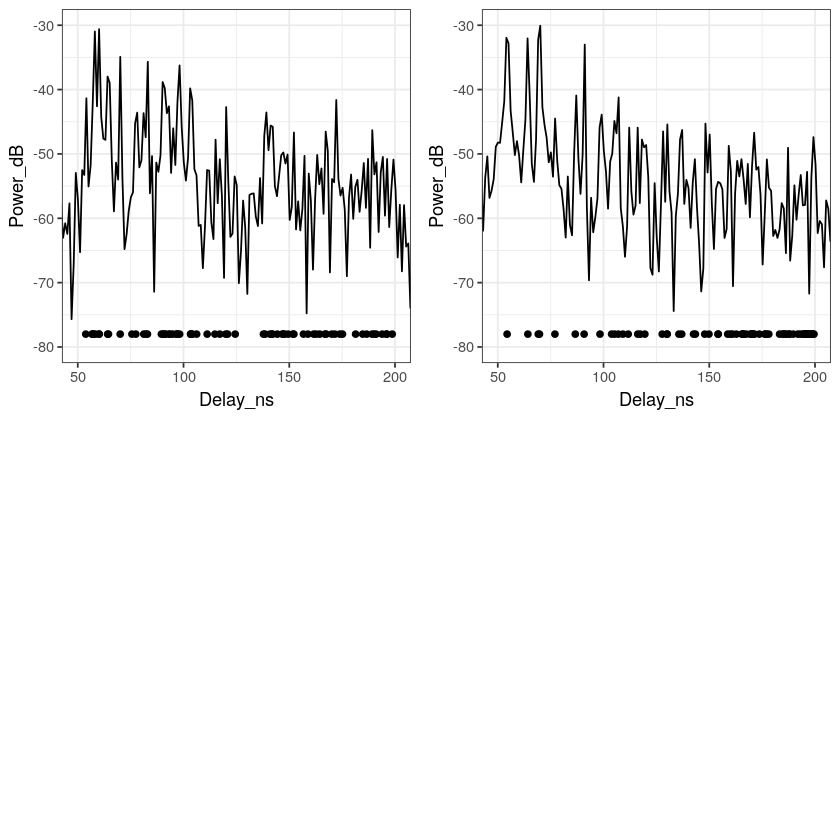

In [25]:
require(gridExtra)           
win <- c(50, 200)

#y-coordinate for multipath components
y_lvl <- -78

plots <- lapply(y_sim, function(y) power_delay_plot( y,
                                                    xlim = win))
plots2 <- lapply(1:2, 
                 function(i) power_delay_plot(y_sim[[i]], xlim = win, dB = T) + 
                 geom_jitter(data = data.frame(x = unlist(points_sim[[i]]$taus), 
                                               y = y_lvl), 
                    aes(x = x, y = y), 
                    width = 0, height = 0) +
                 ylim(-80, -30)
                )
grid.arrange(plots2[[1]], 
             plots2[[2]], 
             nrow = 2, ncol = 2)

## MLE with Known Latents

The first test case for MLE is the setting, where we assume the latent structure to be known. Although actuala measurements do not reveal this kind of information, this test case helps to build intuition on how well maximum likelihood estimation can work in an idealized setting.


As an illustration, we provide **profile plots of the log-likelihood**. That is, we fix all but one of the parameters to be equal to its true value and then see how the log-likelihood changes when varying the remaining parameter.


In general, the plots suggest that at least for the considered realization the log-likelihood is maximized close to the true parameters. Still, we see that even in this idealized setting, we do see deviations, and they will become more pronounced when we consider the case of unknown latent structure in the following sections. 

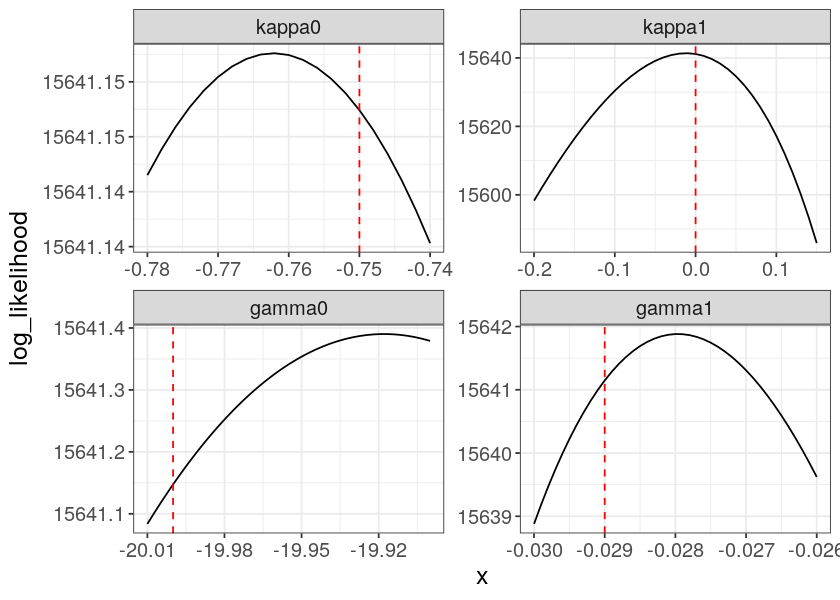

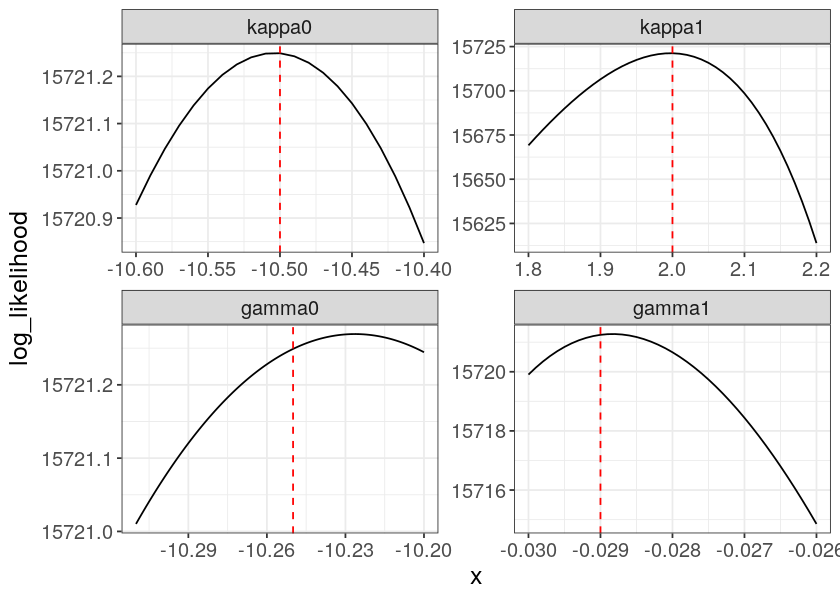

In [27]:
options(repr.plot.width = 7, 
        repr.plot.height = 5)

y_meas <- y_sim[[1]]
profile_plot(function(theta) log_joint(latent_sim[[1]], 
                                       theta),  
            theta_sim[[1]], 
            list(
                 seq(-.78, -.74, by = 2e-3),
                 seq(-.2, .15, by=1e-2),
                 seq(-10.55, -10.45, by= 5e-3),
                 seq(-20.01, -19.9, by=1e-3),
                 seq(-3e-2, -2.6e-2, by=1e-4)
                ),
            theta_sim[[1]],
             c(1:2, 4:5)
           )

y_meas <- y_sim[[2]]
profile_plot(function(theta) log_joint(latent_sim[[2]], 
                                       theta),  
            theta_sim[[2]], 
            list(
                 seq(-10.6, -10.4, by=1e-2),
                 seq(1.8, 2.2, by=1e-2),
                 seq(-10.55, -10.45, by = 5e-3),
                 seq(-10.31, -10.2, by=1e-3),
                 seq(-3e-2, -2.6e-2, by=1e-4)
                ),
            theta_sim[[2]],
             c(1:2, 4:5)
           )

### Conditional Simulation

Of course, when working with actual measurement data, the latent structure is not known. Hence, we next generate samples of the conditional distribution given the data.

In [35]:
#difference between temperature levels
dtemps <- c(6e-2, 6e-2, 4e-2, 5e-2, 4e-2, 4e-2, 3e-2, 2e-2, 2e-2)
ntemps <- length(dtemps) + 1

#generate theta vectors
thetas02 <- lapply(list(theta_sim0, theta_sim2), 
                   function(theta) lapply(1:ntemps, function(i) theta))

for(i in 1:2){
    for(j in 1:ntemps)
        thetas02[[i]][[j]]$logsigma <- thetas02[[i]][[j]]$logsigma + c(0, cumsum(dtemps))[j]
} 

A surprisingly subtle point is the choice of the latent structure used for initializing the MCMC sampler. We found that starting with a random initial configuration produces samples with too many points. This is because despite the option of changing only the marks within the MCMC sampler, it remains difficult to remove misplaced points.

Therefore, we proceed in two steps:
1. Run the MCMC sampler with a random initial configuration.
2. Remove points that are too close together.

In [36]:
seed = 59
set.seed(seed)
npts <- 10

#generate initial latents
latent_init <-  do.call(rbind, 
                        lapply(1:npts,  function(i) rpoint(theta_sim0)))

thin_latent <- function(latent, 
                       thresh = 1){
    #' Remove points that are too close together
    #'
    #' @param latent latent structure to be thinned
    #' @param thresh minimum distance between delays
    
    latent <- latent[order(latent$taus),]
    diffs <- c(diff(latent$taus) > thresh, F)

    ts <- c()
    as <- c()

    cur_tau <- latent$taus[1]
    cur_alpha <- 0

    #accumulate alphas
    for(i in seq(length(diffs))){
        cur_alpha <- cur_alpha + latent$alphas[i]

        #stop accumulating if next point is far away
        if(diffs[i]){
            ts <- c(ts, cur_tau)
            as <- c(as, cur_alpha)

            cur_tau <- latent$taus[i + 1]
            cur_alpha <- 0
        }
    }
    data.frame(taus = ts, alphas = as)
}
latent_sim_cond <- list(0,0)

Next, we use the MCMC sampler to generate 400,000 samples of the latent structure, assuming that we know the true parameter values. To reduce autocorrelation, we retain only every 200th run, so that in total there are 2,000 remaining samples from the conditional distribution.

In [40]:
set.seed(seed)

latent_inits <- list(readRDS('../data/thin_init1.rds'), 
                     readRDS('../data/thin_init2.rds'))

for(i in 1:2){
    y_meas <- y_sim[[i]]
    time <- Sys.time()
    latent_sim_cond[[i]] <- mcmc_pt(function(latent, theta, hf)  log_poisson(latent, theta) + log_gauss(hf, theta), 
                            niter = 4e5,
                            latent_inits[[i]] ,
                            thetas02[[i]],
                            verbose = 5e4)
    print(Sys.time() - time)
}

To assess the burn-in and mixing behavior, we first compute the log-likelihoods.

In [41]:
library(grid)
library(gridExtra)

burn_in <- 500

latent_sim_cond <- readRDS("./long_latent_sep3.rds")

log_liks <- list(0, 0)
nsamp <- dim(latent_sim_cond[[1]])[1]

for(i in 1:2){
    y_meas <- y_sim[[i]]
    log_liks[[i]] <- sapply(burn_in:nsamp, function(j) 
        log_joint(latent_sim_cond[[i]][j,] , thetas02[[i]][[1]]))
}

Plotting the log-likelihood illustrates that after 100,000 iterations the burn-in is reached. 

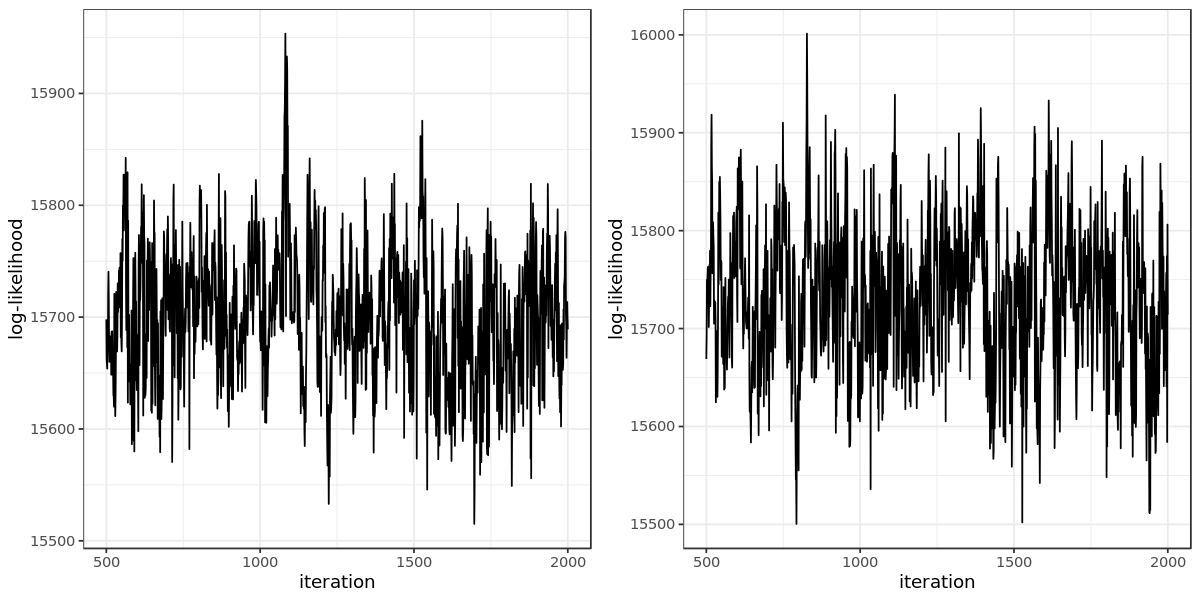

In [82]:
options(repr.plot.width = 10, 
        repr.plot.height = 5)


plots <- lapply(log_liks, function(ll)
                qplot(burn_in:nsamp, ll, geom = "line") +
                    xlab('iteration') +
                    ylab('log-likelihood') + 
                    theme_bw()
                )
grid.arrange(plots[[1]], 
             plots[[2]], 
             ncol = 2 , 
             vp = viewport(width = 1.0,
                           height = 1.0))

An ACF plot illustrates that after sub-sampling and parallel tempering, the autocorrelations remain under control. 

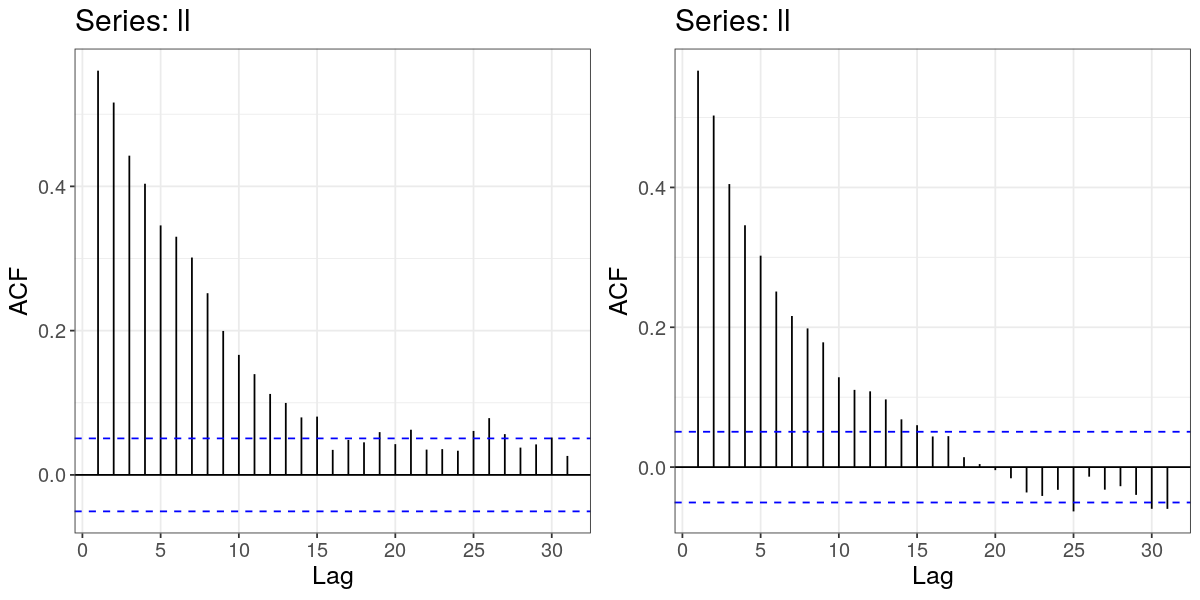

In [45]:
library(forecast)
options(repr.plot.width = 10, 
        repr.plot.height = 5)
plots <- lapply(log_liks, function(ll) ggAcf(ll) +
                theme_bw() + 
                theme(text = element_text(size = font_size)) ) 
grid.arrange(plots[[1]], plots[[2]], 
             ncol = 2,
             vp = viewport(width = 1.0, 
                           height = 1.0))

Looking at the impulse response function reveals that the conditional simulation reproduces the data almost perfectly on the absolute scaling.

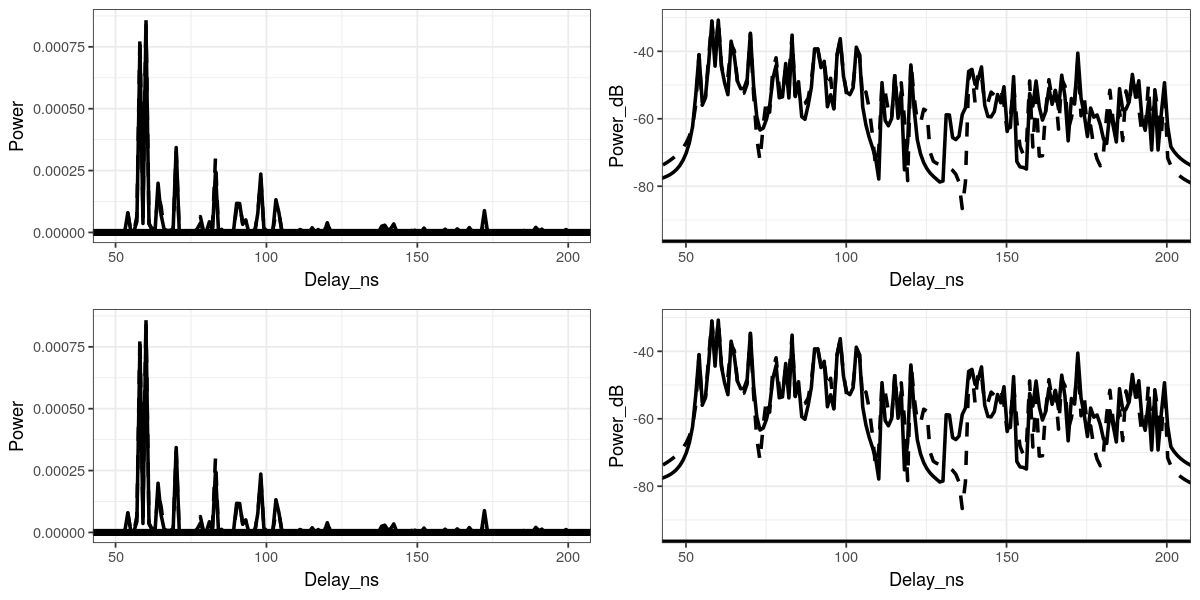

In [50]:
options(repr.plot.width = 10, 
        repr.plot.height = 5)

win = c(50, 200)

plots <- list(0, 0)

for(j in 1:2){
    plots[[j]] <- lapply(1:2, function(i) power_delay_plot(list(0 * latent_sim_cond[[1]]$ct[[100]],
                                                                latent_sim_cond[[1]]$ct[[100]], 
                                                                latent_sim[[1]]$ct[[1]]),
                                                      xlim = win,
                                                      dB = c(F, T)[j]))
}          

grid.arrange( plots[[1]][[1]], plots[[2]][[1]], 
             plots[[1]][[2]] , plots[[2]][[2]], 
             nrow = 2, ncol = 2)

Next, we plot the profile log-likelihood plots based on the MCMC sample. Both for $\kappa_1 = 0$ and for $\kappa_1 = 2$, we see a similar picture as with known latents. Since we only inspect a single realization, the log-likelihood is not maximized at the true parameters. Later, we will perform a broader simulation study to see how strongly the estimates fluctuate from one realization to another.

In [ ]:
latent_sim_cond <-  readRDS("./long_latent_sep3.rds")
y_meas <- y_sim[[1]]
loglik_avg_plot( 
            function(latent, theta)
             log_joint(latent, theta) - log_joint(latent, theta_sim[[1]]),
            latent_sim_cond[[1]][burn_in:nsamp,], 
            theta_sim[[1]], 
            list(
                 seq(-.75, -.5, by = 5e-2),
                 seq(-.01, .07, by = 1e-2),
                 seq(-10.50, -10.45, by = 1e-2),
                  seq(-20.4, -19.95, by = 5e-2),
                 seq(-3.1e-2, -2.7e-2, by = 5e-4)
                ),
           theta_sim[[1]]
           )


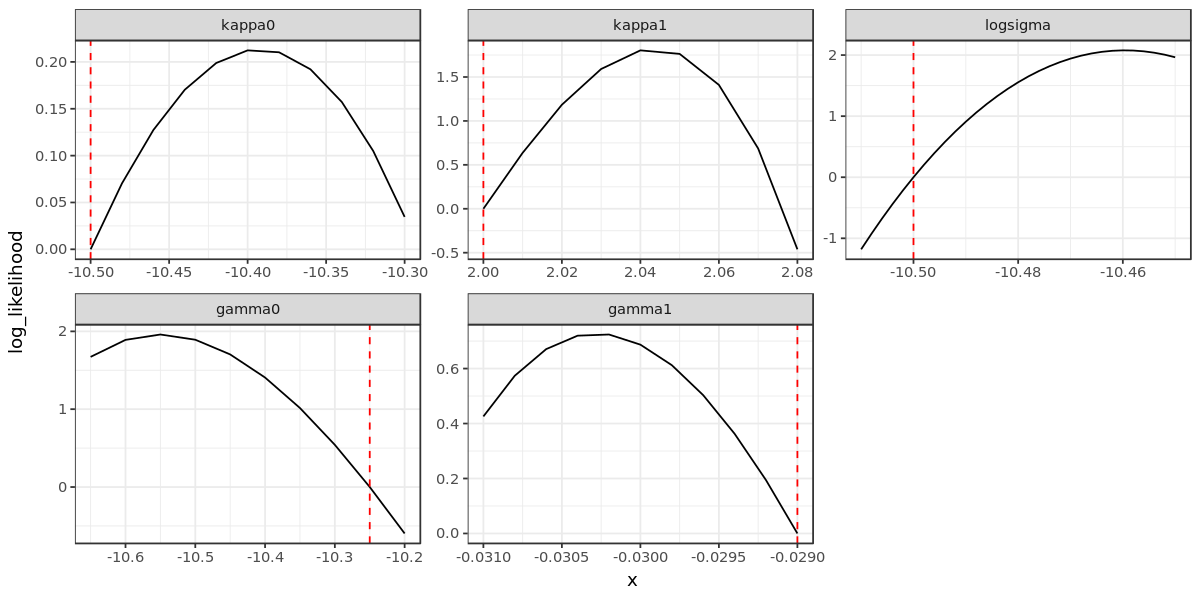

In [83]:
y_meas <- y_sim[[2]]
loglik_avg_plot(
            function(latent, theta)
             (log_joint(latent, theta) - log_joint(latent, theta_sim[[2]])),
            latent_sim_cond[[2]][burn_in:nsamp,], 
            theta_sim[[2]], 
            list(
                 seq(-10.5, -10.3, by = 2e-2),
                 seq(2, 2.08, by = 1e-2),
                 seq(-10.51, -10.45, by = 2e-3),
                 seq(-10.65, -10.2, by = 5e-2),
                 seq(-3.1e-2, -2.9e-2, by = 2e-4)
                ),
           theta_sim[[2]]
           )

## Model Selection

A possible application of the likelihood-ratio computation is **model selection**. That is, given specific parameters $\theta_0$ and $\theta$, we think of the model with parameters $\theta$ to provide a better fit if ${c_{\theta}}/{c_{\theta_0}} > 1$. As discussed above, this ratio can in principle be estimated via MCMC sampling.

However, if $\theta_0$ and $\theta$ are far apart, then a direct MCMC-based estimation of the ratio $c_{\theta} / c_{\theta_0}$ is unreliable, since the weights are almost degenerate. This problem can be tackled via **bridge sampling**, where the ratio is expanded as 
$$\frac{c_{\theta}}{c_{\theta_0}} = \frac{c_{\theta_1}}{c_{\theta_0}}\frac{c_{\theta_2}}{c_{\theta_1}} \cdots \frac{c_{\theta_{n - 1}}}{c_{\theta_n}}$$
for intermediate parameters $\theta_1, \ldots, \theta_n$ that figuratively bridge the large difference between $\theta_0$ and $\theta$.

To illustrate this concept, we draw a realization under $\kappa_1 = 0$ and then compare this with the parameter set where $\kappa_1 = 2$. We choose $n = 4$ intermediate levels, where we leave the parameters $\log \sigma$, $\gamma_0$ and $\gamma_1$ constant. In $\kappa_1$, we interpolate linearly between the boundaries $0$ and $2$, and we choose $\kappa_0$ such that the total intensity is preserved approximately.

In [52]:
k1vals <- seq(0, 2.0, by = .4)
k0vals <- c(-.75, -2.7, -4.7, -6.6, -8.6, -10.5)
g0vals <- theta_sim0$gamma0 - k0vals + theta_sim0$kappa0
nbridge <- length(k1vals)

thetas_bridge <- lapply(1:6, function(i) theta_sim0)
thetas_bridge <- do.call("rbind", thetas_bridge)
thetas_bridge$kappa0 <- k0vals
thetas_bridge$kappa1 <- k1vals
thetas_bridge$gamma0 <- g0vals
thetas_bridge <- split(thetas_bridge, 1:nbridge)
                        
#difference between temperature levels
dtemps <- c(6e-2, 6e-2, 4e-2, 5e-2, 4e-2, 4e-2, 3e-2, 2e-2, 2e-2)
ntemps <- length(dtemps) + 1 

#generate theta vectors
thetas_bridge <- lapply(1:nbridge, 
                   function(i) lapply(1:ntemps, function(j) thetas_bridge[[i]]))

for(i in 1:nbridge){
    for(j in 1:ntemps)
        thetas_bridge[[i]][[j]]$logsigma <- 
            thetas_bridge[[i]][[j]]$logsigma + c(0, cumsum(dtemps))[j]
}   

Now, we generate the realizations.

In [53]:
seed <-7
set.seed(seed)

latents_bridge <- vector(mode = "list", length = 6)
y_meas <- y_sim[[1]]

for(i in 1:(nbridge - 1)){
    latents_bridge[[i]] <- mcmc_pt(function(latent, theta, ct) 
                                    log_gauss(ct, theta) + log_poisson(latent, theta), 
                            niter = 4e5,
                            points_sim[[1]],
                            thetas_bridge[[i]],
                            verbose = 1e5)
}

 As a preliminary step, we evaluate the likelihood ratio for a given realization of the latent structure.

In [54]:
eval_lik_rat <- function(latents,
                         theta,
                         theta0){
    #' Evaluate the likelihood ratio at specific values
    #'
    #' @param latents latent structure for computing the ratio 
    #' @param theta target parameter
    #' @param theta0 base parameter
    
    ll0 <- sapply(1: (dim(latents)[1]), function(j) {
        log_joint(latents[j,] , theta) - 
        log_joint(latents[j,] , theta0)
    })
    lik_rat(ll0)
}

After having generated the MCMC samples for the intermediate values, we can now compute the likelihood ratios. We repeat this procedure 100 times.

In [55]:
ssize <- 100
br <- vector(mode="list",  length = ssize)

for(idx in 0:(ssize - 1)){
y_meas <- readRDS(paste0("../bridge/data/y0_", idx, ".rds"))
latents_bridge <- readRDS(paste0("../bridge/data/latent_bridge0_", idx, ".rds"))
bridge_ratios <- mclapply(1:5,
                          function(i)
                              eval_lik_rat(latents_bridge[[i]],
                                           thetas_bridge[[i + 1]][[1]],
                                           thetas_bridge[[i]][[1]]
                                           ),
                          mc.cores = 16
                        )
message(colSums(do.call('rbind', bridge_ratios))[1])
br[[idx + 1]] <- colSums(do.call('rbind', bridge_ratios))[1]
    }

Warning message in gzfile(file, "rb"):
“cannot open compressed file '../bridge/data/latent_bridge0_0.rds', probable reason 'Bestand of map bestaat niet'”

ERROR: Error in gzfile(file, "rb"): cannot open the connection


In [59]:
ssize <- 100
br <- vector(mode="list",  length = ssize)

for(idx in 0:(ssize - 1)){
y_meas <- readRDS(paste0("../bridge/data/y0_", idx, ".rds"))
latents_bridge <- readRDS(paste0("../bridge/data/latent_bridge0_", idx, ".rds"))
bridge_ratios <- lapply(1:(nbridge - 1),
                          function(i)
                              eval_lik_rat(latents_bridge[[i]],
                                           thetas_bridge[[i + 1]][[1]],
                                           thetas_bridge[[i]][[1]]
                                           ),
                          mc.cores = 16
                        )
message(colSums(do.call('rbind', bridge_ratios))[1])
br[[idx + 1]] <- colSums(do.call('rbind', bridge_ratios))[1]
    }

-13.4154203255648


We see that the Monte Carlo estimates for each of the samples are negative and supported by an ESS of at least 300. The aggregate log-likelihood equals $-13.4$. Hence, MLE would favor the constant over the quadratic rate model.

In [60]:
bridge_ratios
colSums(do.call('rbind', bridge_ratios))[1]

[[1]]
[1]   0.4465738 590.3497860

[[2]]
[1]   -2.65155 1133.28287

[[3]]
[1]  -1.87465 356.81583

[[4]]
[1]   -5.413302 1128.665088

[[5]]
[1]  -3.922492 341.833457

[1] -13.41542

The investigations reveals that in all of the cases the bridge ratio assigns a higher likelihood to the true model.

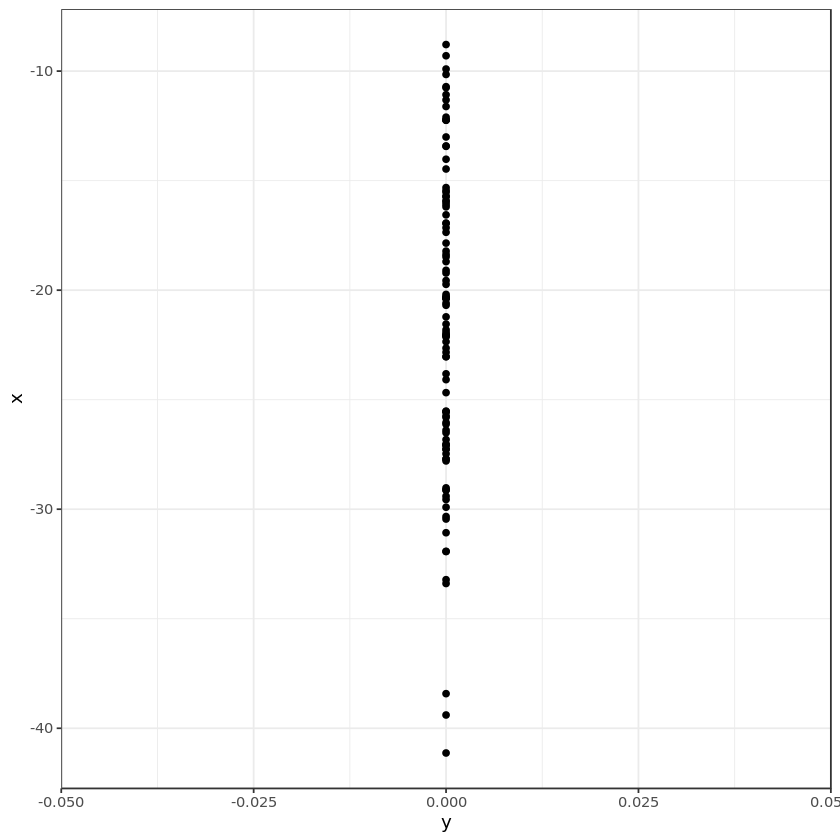

In [21]:
library(ggplot2)
ggplot(data.frame(x = unlist(br), y = 0), aes(x = y, y = x)) +
    geom_jitter(position = position_jitter(0)) +
    theme_bw()


Conversely, now we draw samples from the quadratic rate model and perform bridge sampling to compute the log-likelihood ratio when comparing to the constant rate model.

In [68]:
length(latents_bridge[[5]])

[1] 2

In [70]:
ssize <- 100
br <- vector(mode="list",  length = ssize)

for(idx in 0:(ssize - 1)){
y_meas <- readRDS(paste0("../bridge2/data/y2_", idx, ".rds"))
latents_bridge <- readRDS(paste0("../bridge2/data/latent_bridge2_", idx, ".rds"))
bridge_ratios <- mclapply(1:(nbridge - 1),
                          function(i)
                              eval_lik_rat(latents_bridge[[6 - i]],
                                           thetas_bridge[[6 - i]][[1]],
                                           thetas_bridge[[7 - i]][[1]]
                                           ),
                          mc.cores = 16
                        )
message(colSums(do.call('rbind', bridge_ratios))[1])
br[[idx + 1]] <- colSums(do.call('rbind', bridge_ratios))[1]
    }

-12.1808524205373
-5.63532235901436
-12.4720008318758


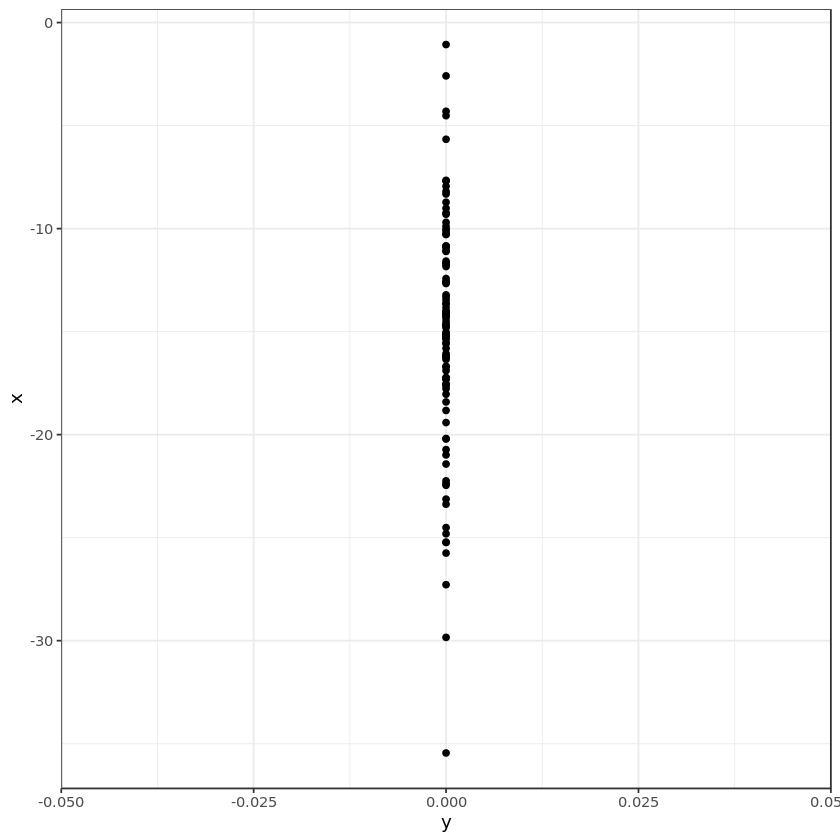

In [26]:
library(ggplot2)
ggplot(data.frame(x = unlist(br), y = 0), aes(x = y, y = x)) +
    geom_jitter(position = position_jitter(0)) +
    theme_bw()


## Monte Carlo MLE

Based on the MCMC samples from the conditional distribution, we now optimize the likelihood ratio $c_\theta / c_{\theta_0}$ over the parameter $\theta$.

### Parameter Dependencies

Finding the optimal parameter $\theta$ is complicated by subtle dependencies between the parameters. For instance, both $\kappa_0$ and $\kappa_1$ affect the total intensity of points, and, similarly, both $\gamma_0$ and $\gamma_1$ affect influence the general size of the path gains. 

This causes problems for CEM, which relies on a Gaussian proposal distribution with diagonal covariance structure. If the parameters are too tightly entangled, the optimization explores the parameter space poorly.


To illustrate the parameter dependencies between $\kappa_0$ and $\kappa_1$ further, we plot the 2D profile likelihood depending on both intensity parameters. The contour plot reveals a strong negative linear dependence.

In [43]:
n_mesh <- 20
y_meas <- y_sim[[1]]

k0_range <- seq(-1.2, -0.5, length.out = n_mesh)
k1_range <- seq(-.1, .1, length.out = n_mesh)

lj_surf <- compute_df_surface(function(theta) 
    eval_lik_rat(latent_sim_cond[[1]], 
                 theta,
                 theta_sim[[1]])[1],  
                   theta_sim[[1]],
                   1:2,
                   k0_range,
                   k1_range)

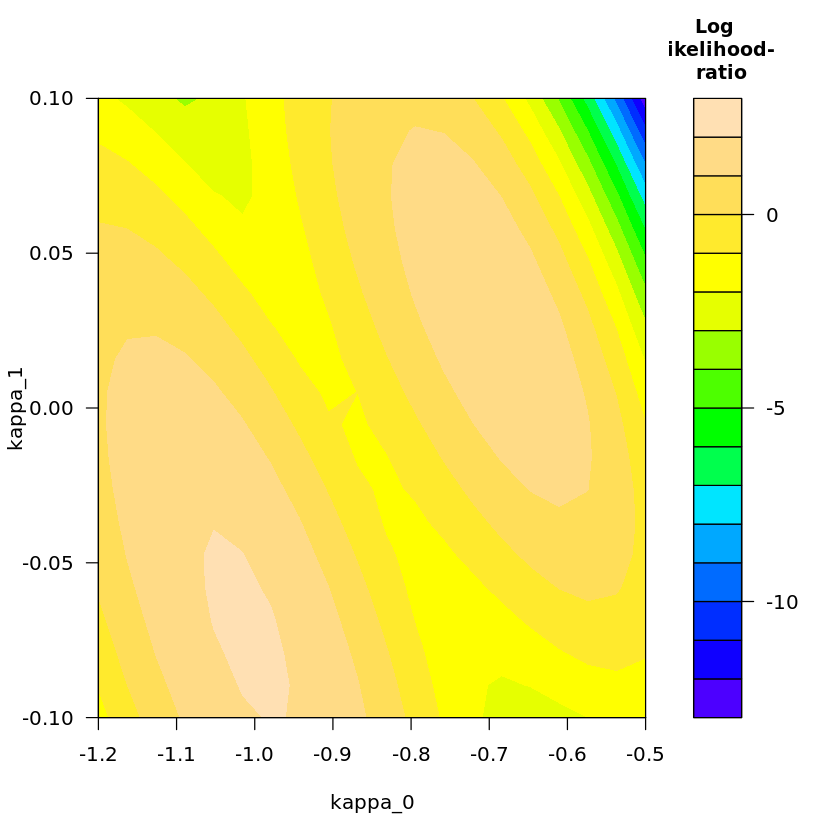

In [80]:
filled.contour(x = k0_range,
               y = k1_range,
               z = lj_surf,
               color.palette = topo.colors,
              xlab = 'kappa_0',
              ylab = 'kappa_1',
              key.title = title(main="Log \n likelihood- \n ratio",
                               cex.main = .95))

###  Fixed $\kappa_1$

After these initial findings, we now rely on the conditional samples to estimate the model parameters from the simulated model. First, we fix $\kappa_1$ at its true value. We perturb some of the other parameters and then find an approximate maximum of the log-likelihood via the CEM.

In [15]:
theta_sim_mod <- theta_sim

theta_sim_mod <- list(theta_sim0, theta_sim2)
theta_sim_mod[[1]][1,] <- c(-.6, 0, -10.5, -20, -.029, 50, 150, 0, 1000)
theta_sim_mod[[2]][1,] <- c(-10.3, 2, -10.5, -10.25, -.029, 50, 150, 0, 1000)

print(exp_points(theta_sim_mod[[1]]))
print(exp_points(theta_sim_mod[[2]]))

[1] 82.32175
[1] 88.28687


Next, we set up a preconditioning matrix reflecting the parameter dependencies uncovered in the previous section. There is some difference in the slope between the situation when $\kappa_1 = 0$ and when $\kappa_1 = 2$, but the cross-entropy method does not need perfect decorrelation. 

In [27]:
simple_precond  <- matrix(
    c(1, 4.7, 0, 0, 0,
    0, 1, 0, 0, 0,
     0, 0, 1, 0, 0,
     0, -3.8 , 0, 1, 0,
     0,  -3.8 * .7, 0, .7, 100),
    nrow = 5, byrow = T
)

We start by optimizing when $\kappa_1 = 0$. In order to separate the effects of the optimization from the choice of a good initial value, we initialize the MCMC chain with the true latent structure.

In [23]:
#generate theta vectors
dtemps <- c(6e-2, 6e-2, 4e-2, 5e-2, 4e-2, 4e-2, 3e-2, 2e-2, 2e-2)
ntemps <- length(dtemps) + 1
thetas <- lapply(1:ntemps, function(i) theta_sim_mod[[1]])
                 
for(i in 1:ntemps)
    thetas[[i]]$logsigma <- thetas[[i]]$logsigma + c(0, cumsum(dtemps))[i]

y_meas <- y_sim[[1]]
auto_cem_optim(points_sim[[1]],
               thetas,
               simple_precond,
               sd_init = c(1, 0, 1, 1, 1),
               theta_fname = "../data/theta_0fixed.csv")

inside cem


  kappa0 kappa1 logsigma gamma0 gamma1 tau0 win_size loglik ess
1   -0.6      0    -10.5    -20 -0.029   50      150      0 749
Time difference of 0.01229501 secs


Next, we repeat with $\kappa_1 = 2$.

In [25]:
#generate theta vectors
thetas <- lapply(1:ntemps, function(i) theta_sim_mod[[2]])
for(i in 1:ntemps)
    thetas[[i]]$logsigma <- thetas[[i]]$logsigma + c(0, cumsum(dtemps))[i]

y_meas <- y_sim[[2]]
auto_cem_optim(points_sim[[2]],
               thetas,
               simple_precond,
               sd_init = c(1, 0, 1, 1, 1),
               theta_fname = "../data/theta_2fixed.csv")

inside cem


  kappa0 kappa1 logsigma gamma0 gamma1 tau0 win_size loglik ess
1  -10.3      2    -10.5 -10.25 -0.029   50      150      0 749
Time difference of 0.0105226 secs


### Variable $\kappa_1$

Next, we also include $\kappa_1$ in the optimization process. Again, we start with $\kappa_1 = 0$...

In [27]:
#generate theta vectors
thetas <- lapply(1:ntemps, function(i) theta_sim_mod[[1]])
for(i in 1:ntemps)
    thetas[[i]]$logsigma <- thetas[[i]]$logsigma + c(0, cumsum(dtemps))[i]

y_meas <- y_sim[[1]]
auto_cem_optim(points_sim[[1]],
               thetas,
               simple_precond,
               sd_init = c(1, 1, 1, 1, 1),
               theta_fname = "../data/theta_0var.csv")

inside cem


  kappa0 kappa1 logsigma gamma0 gamma1 tau0 win_size loglik ess
1   -0.6      0    -10.5    -20 -0.029   50      150      0 749
Time difference of 0.01144361 secs


... and move to $\kappa_1 = 2$ afterwards.

In [28]:
#generate theta vectors
thetas <- lapply(1:ntemps, function(i) theta_sim_mod[[2]])
for(i in 1:ntemps)
    thetas[[i]]$logsigma <- thetas[[i]]$logsigma + c(0, cumsum(dtemps))[i]


y_meas <- y_sim[[2]]
auto_cem_optim(points_sim[[2]],
               thetas,
               simple_precond,
               sd_init = c(1, 1, 1, 1, 1),
               theta_fname = "../data/theta_2var.csv")

inside cem


  kappa0 kappa1 logsigma gamma0 gamma1 tau0 win_size loglik ess
1  -10.3      2    -10.5 -10.25 -0.029   50      150      0 749
Time difference of 0.01103115 secs


# Robustness of Estimates

The estimation above is based on a single realization of simulated data. In order to see how robust these estimates are when drawing a different realization, we repeat the estimation procedure for 50 iid samples.

In [32]:
theta_lists <- lapply(c(0, 2), 
                      function(i){
                          thetas <- lapply(0:49, function(j){
                            theta_trace <- read.csv(paste0("../fixed",
                                                           i,
                                                           "/theta/theta",
                                                           i, 
                                                           "_",
                                                           j ,
                                                           ".csv"))
                            theta_trace[dim(theta_trace)[1], c(1, 3:5)]}
                                )
                          }
                      )

#convert to df
theta_dfs <- lapply(theta_lists, function(theta_list)
                do.call('rbind', theta_list)
    )

A visualization of the fitted values reveals that both for $\kappa_1 = 0$ and for $\kappa_1 = 2$ the estimates for the parameters do fluctuate, but the expectation is close to the true value.

Using  as id variables
Using  as id variables


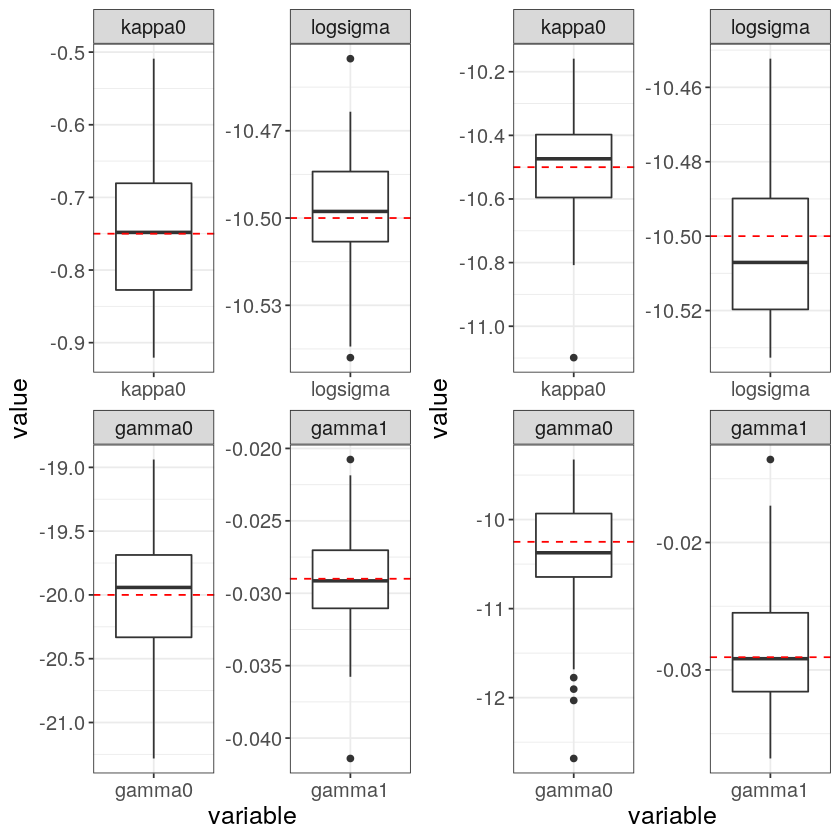

In [23]:
library(grid)
library(gridExtra)
library(reshape)
library(ggplot2)

font_size = 15

true_theta0 <- data.frame(variable=(colnames(theta_dfs[[1]])), 
                                           Z = c(-.75,  -10.5, -20, -.029))
true_theta2 <- data.frame(variable=(colnames(theta_dfs[[2]])), 
                                           Z = c(-10.5,  -10.5, -10.25, -.029))
true_thetas <- list(true_theta0, true_theta2)

melt.dfs <- lapply(theta_dfs, 
                   function(df) melt(df))
plots <- lapply(1:2, function(i)
    ggplot(melt.dfs[[i]], aes(x = variable, y = value)) + 
    geom_boxplot() +
    facet_wrap(~variable, scale="free") + 
    geom_hline(data = true_thetas[[i]], 
                    aes(yintercept = Z),
                    linetype="dashed",
                    color = 'red')  +
    theme_bw() +
    theme(text = element_text(size = font_size)) 
) 
                
grid.arrange(plots[[1]], 
             plots[[2]], 
             ncol = 2)

Next, we optimize over all parameters.

In [35]:
theta_lists <- lapply(c(0, 2), 
                      function(i){
                          thetas <- lapply(0:49, function(j){
                            theta_trace <- read.csv(paste0("../variable",
                                                           i,
                                                           "/theta/theta",
                                                           i, 
                                                           "_",
                                                           j ,
                                                           ".csv"))
                            theta_trace[dim(theta_trace)[1], c(1:2,4:5)]}
                                )
                          }
                      )

#convert to df
theta_dfs <- lapply(theta_lists, function(theta_list)
                rbind(do.call('rbind', theta_list))
    )

#compute medians
medians <- lapply(1:2, function(i)
                apply(theta_dfs[[i]], 2, median))

Using  as id variables
Using  as id variables


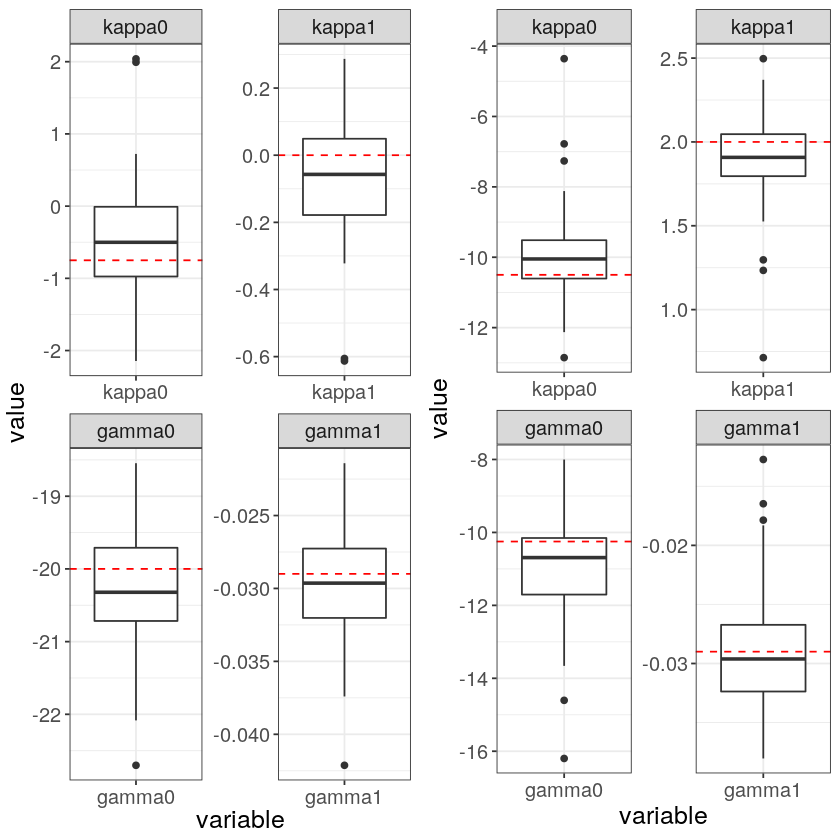

In [25]:
library(grid)
library(gridExtra)
library(reshape)
library(ggplot2)

true_theta0 <- data.frame(variable=(colnames(theta_dfs[[1]])), 
                                           Z = c(-.75,  0, -20, -.029))
true_theta2 <- data.frame(variable=(colnames(theta_dfs[[2]])), 
                                           Z = c(-10.5, 2, -10.25, -.029))
true_thetas <- list(true_theta0, true_theta2)

melt.dfs <- lapply(theta_dfs, 
                   function(df) melt(df))
plots <- lapply(1:2, function(i)
    ggplot(melt.dfs[[i]], aes(x = variable, y = value)) + 
    geom_boxplot() +
    facet_wrap(~variable, scale="free") + 
    geom_hline(data = true_thetas[[i]], 
                    aes(yintercept = Z),
                    linetype="dashed",
                    color = 'red')  +
    theme_bw() +
    theme(text = element_text(size = font_size)) 
)
                
grid.arrange(plots[[1]], 
             plots[[2]], 
             ncol = 2)

Finally, we add pairwise scatterplots to illustrate the parameter dependencies.

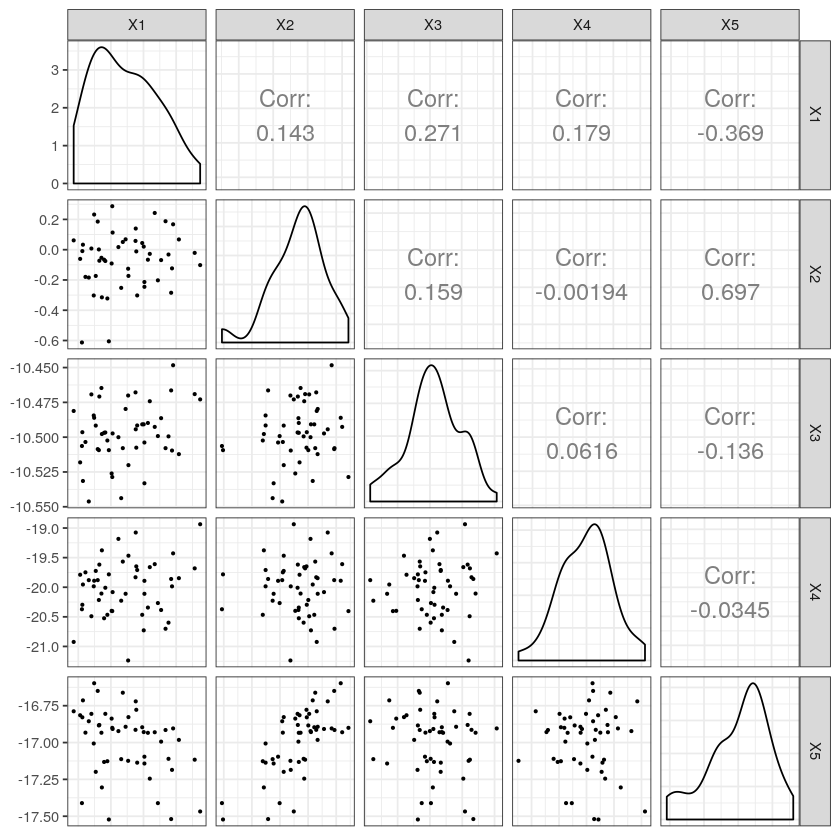

In [36]:
library(GGally)
options(repr.plot.width=7, repr.plot.height=7)

#precondition
theta_trans <- as.matrix(theta_dfs[[1]]) %*% t(simple_precond)
theta_trans <- data.frame(theta_trans)

plot <- ggpairs(theta_trans,
               mapping = ggplot2::aes(size = I(.5)),
                upper = list(continuous = wrap("cor", size = 5))
               ) +
        theme_bw() + 
        theme(axis.text.x=element_blank(),
              axis.ticks.x=element_blank())
plot


## Wei's Data

After the analysis of simulated data, we now turn to [indoor channel data](https://link.springer.com/article/10.1186/s13638-016-0548-x).

### Exploratory Analysis

The data contains the channel response for $750$ equally-spaced measurements in the range $[2\text{ GHz}, 3\text{ GHz}]$. In particular, the impulse response lies in the interval from $0$ to $T = 750 \text{ ns}$. The impulse response exhibits a strong peak at the beginning and then decays rapidly. Therefore, we henceforth work with a reduced window of size 150.

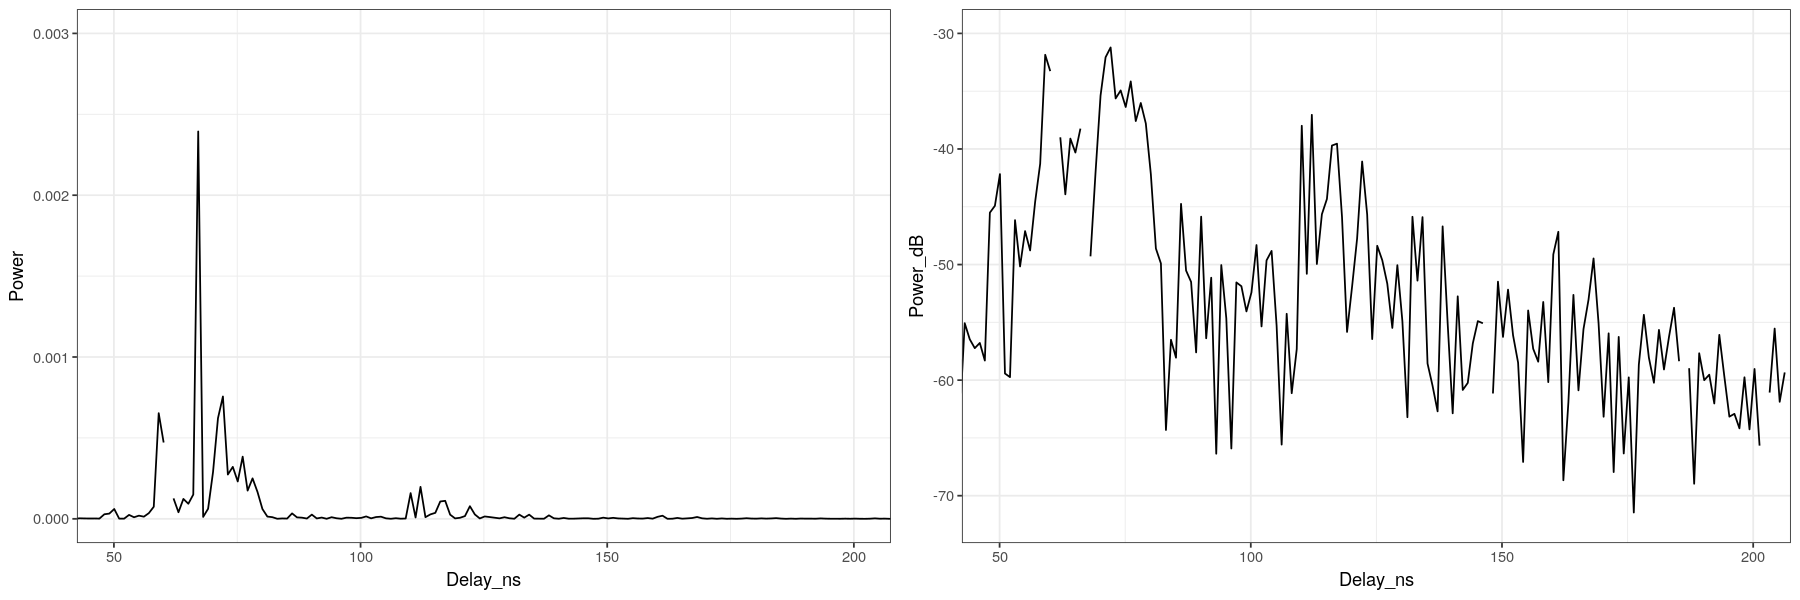

In [39]:
options(repr.plot.width = 15, 
        repr.plot.height = 5)
freqs <- - 2 * pi * 1i *  seq(2, 3, length.out=750)
win <- c(50, 200)
y_meas <- read.csv("../wei/data/weiNLOS.csv", header = F)[[1]]
require(gridExtra)        
require(grid)
plots <- power_delay_plot( y_meas, xlim = win)+
                 ylim(0, 3e-3)
plots2 <-  power_delay_plot(y_meas, 
                            xlim = win, 
                            dB = T) +
                 ylim(-72, -30)
grid.arrange(plots, plots2,  
             ncol = 2)

As we saw in the simulation section, the optimization is prone to become unstable when considering all parameters simultaneously. Hence, we study two alternatives: a constant rate model with $\kappa_1 = 0$ and a quadratically increasing intensity with $\kappa_1 = 2$. We fix the remaining values for the initial parameters via a pilot run.

In [47]:
seed=48
set.seed(seed)

#initialize theta
theta_wei0 <- data.frame(kappa0 = 0.2,
                         kappa1 = 0,
                         logsigma = -10.585,
                         gamma0 = -18.2,
                         gamma1 = -.053,
                         tau0 = 50,
                         win_size = 150,
                         loglik = 0,
                         ess = 1000)
 

theta_wei2 <- theta_wei0
theta_wei2$kappa1 <- 2
theta_wei2$kappa0 <- -8.55
theta_wei2$gamma1 <- -.05
theta_wei2$gamma0 <- -9.85

theta_wei <- list(theta_wei0, theta_wei2)

For the remaining steps, we proceed as for the simulated data.

In [42]:
#initialize latent structure
n_wei <- sapply(theta_wei, function(theta) floor(exp_points(theta)))
n_wei
npts <- 5
latent_wei <- do.call(rbind, 
                        lapply(1:npts,  function(i) rpoint( theta_wei[[1]])))

[1] 150 323

To create an initial value for the latent structure, we proceed as for the simulated data. That is, we first simulate the latent structure given the data and then apply thinning in order to remove redundant points.

We found that for $\kappa_1 = 2$ the optimization oscillates close to a fixed limiting value. In order to stabilize fitting, we increased  the number of MCMC samples for the optimization from 1,500 to 2,500.

In [46]:
#generate theta vectors
dtemps <- c(4e-2, 6e-2, 4e-2, 5e-2, 3e-2, 4e-2, 3e-2, 3e-2, 2e-2)
ntemps <- length(dtemps) + 1
thetas <- lapply(1:ntemps, function(i) theta_wei[[1]])
                                
#load initial configuration
wei_init <- readRDS("../wei/wei_thinned.rds")
                 
for(i in 1:ntemps)
    thetas[[i]]$logsigma <- thetas[[i]]$logsigma + c(0, cumsum(dtemps))[i]

auto_cem_optim(wei_init,
               thetas,
               simple_precond,
               sd_init = c(1, 0, 1, 1, 1),
               theta_fname = "../data/wei/theta_wei_2.csv")

inside cem


  kappa0 kappa1 logsigma gamma0 gamma1 tau0 win_size loglik ess
1      0      0    -10.5    -20 -0.029   50      150      0 749
Time difference of 0.0106082 secs


In [48]:
#generate theta vectors
thetas <- lapply(1:ntemps, function(i) theta_wei[[2]])
dtemps <- c(4e-2, 6e-2, 5e-2, 5e-2, 5e-2, 4e-2, 3e-2, 3e-2, 3e-2)
                                
#load initial configuration
wei_init <- readRDS("../wei/wei_thinned.rds")
                 
for(i in 1:ntemps)
    thetas[[i]]$logsigma <- thetas[[i]]$logsigma + c(0, cumsum(dtemps))[i]

auto_cem_optim(wei_init,
               thetas,
               simple_precond,
               sd_init = c(1, 0, 1, 1, 1),
               theta_fname = "../data/wei/theta_wei_0.csv")

inside cem


  kappa0 kappa1 logsigma gamma0 gamma1 tau0 win_size loglik ess
1  -8.55      2  -10.585  -9.85  -0.05   50      150      0 749
Time difference of 0.01835704 secs


Next, we trace the parameter plots. While the value for $\log(\sigma)$ is similar both for $\kappa_1 = 0$ and $\kappa_1 = 2$, the estimates for the other parameters differ substantially.

### Bridge sampling 

To decide whether the model with quadratically increasing intensity is a better fit to the measurement data than the constant rate model, we evaluate the ratio $c_{\theta_{\kappa_1 = 2}} / c_{\theta_{\kappa_1 = 0}}$ via bridge sampling.

In [49]:
thetas_wei <- list(read.csv("../wei/data/theta_wei.csv"),
                   read.csv("../wei/data/theta_wei2.csv"))
thetas_wei <- lapply(1:2, function(i)
                        thetas_wei[[i]][dim(thetas_wei[[i]])[1], ])
thetas_wei

,kappa0,kappa1,logsigma,gamma0,gamma1,tau0,win_size,loglik,ess
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>
6,0.1865228,0,-10.5861,-18.07185,-0.05322408,50,150,0.08456404,1420.58
,kappa0,kappa1,logsigma,gamma0,gamma1,tau0,win_size,loglik,ess
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>
12,-8.54053,2,-10.5846,-9.210266,-0.05407599,50,150,0.09171992,2128.585


In the bridge sampling, we interpolate between $\kappa_1 = 0$ and $\kappa_1 = 2$ in steps of size 0.125. We also interpolate linearly in the remaining parameters.

In [50]:
#linear interpolation between the parameter vectors
nbridge <- 17
thetas_bridge <- lapply(1:9, function(i) seq(thetas_wei[[1]][dim(thetas_wei[[1]])[1], i], 
                            thetas_wei[[2]][1, i], 
                            length.out = nbridge)
       )
thetas_bridge <- do.call('cbind', thetas_bridge)
colnames(thetas_bridge) <- colnames(thetas_wei[[1]])
thetas_bridge = data.frame(thetas_bridge)

#number of temperature levels
dtemps <- c(3e-2, 6e-2, 4e-2, 5e-2, 3e-2, 4e-2, 3e-2, 3e-2, 2e-2)
ntemps <- length(dtemps) + 1


#generate theta vectors
thetas_bridge <- lapply(1:nbridge,
                   function(i) lapply(1:ntemps, function(j) thetas_bridge [i,]))
for(i in 1:nbridge){
    for(j in 1:ntemps)
        thetas_bridge[[i]][[j]]$logsigma <-
            thetas_bridge[[i]][[j]]$logsigma + c(0, cumsum(dtemps))[j]
}

Now, we generate the realizations.

In [53]:
seed <-7
set.seed(seed)

wei_init <- readRDS("../wei/wei_thinned.rds")

latents_bridge <- vector(mode = "list", length = nbridge)

for(i in 1:(nbridge - 1)){
latents_bridge[[i]] <- mcmc_pt(function(latent, theta, ct) log_gauss(ct, theta) + log_poisson(latent, theta),
                          niter = 6e5,
                          wei_init,
                          thetas_bridge[[i]],
                          verbose = 2e5)
}

To proceed, we can load the previously stored realizations.

In [7]:
burn_in = 501
nsamp = 3000

latents_bridge <- lapply(1:(nbridge - 1), 
             function(i) readRDS(paste0('../wei/data/latent_bridge_wei', i,'.rds'))[burn_in:nsamp,]
             )

To select the appropriate model, we compute and plot the log-likelihood ratios in each of the bridge steps.

In [21]:
library(parallel)
library(VGAM)
bridge_ratios <- mclapply(1:(nbridge - 1),
                          function(i)
                              eval_lik_rat(latents_bridge[[i]],
                                           thetas_bridge[[i + 1]][[1]],
                                           thetas_bridge[[i]][[1]]
                                           ),
                          mc.cores = 4
                        )
log_lik_values <- sapply(bridge_ratios, function(x) x[[1]])
                         log_lik_values

[1] -0.396633123 -0.001731706 -0.457400627 -0.177939586 -0.265618722
 [6] -0.446100080 -0.764686061 -0.303743077 -0.370353082 -0.253960809
[11] -0.134509625 -0.830650512 -1.434631396 -1.267534923 -0.751474452
[16] -0.889843119

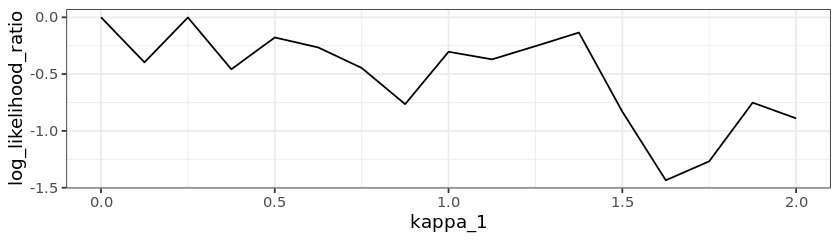

In [22]:
library(reshape)
library(ggplot2)

options(repr.plot.width = 1, 
        repr.plot.height = 22)

trace <- data.frame(kappa_1 = seq(0, 2, length.out = nbridge), 
                    log_likelihood_ratio = c(0, log_lik_values))

options(repr.plot.width=7, repr.plot.height=2)

ggplot(data = trace, aes(kappa_1, log_likelihood_ratio)) + 
    geom_line() + 
    theme_bw()    

Finally, we compare realizations from the unconditional model.

In [54]:
seed <- 1
set.seed(seed)

#generate location of delays
theta_weis <- list(thetas_bridge[[1]][[1]], thetas_bridge[[nbridge]][[1]])
n_wei <- sapply(theta_weis, function(theta) floor(exp_points(theta)))
points_sim <- lapply(1:2, 
     function(i) do.call(rbind, 
                         lapply(1:(n_wei[[i]]), 
                                function(j) rpoint(theta_weis[[i]])))
     )

#comput channel transfer                         
latent_wei <- lapply(1:2, function(i) data.frame(latent=0, ct=0))
latent_wei[[1]][1,] <- list(list(points_sim[[1]]),
                       list(rowSums(h_freq(points_sim[[1]]))))
latent_wei[[2]][1,] <- list(list(points_sim[[2]]),
                       list(rowSums(h_freq(points_sim[[2]]))))

#add thermal noise
y_wei <- lapply(1:2, function(i) latent_wei[[i]]$ct[[1]] + 
         rnorm(n=length(freqs), sd=exp(theta_weis[[i]]$logsigma)) + 
    1i * rnorm(n=length(freqs), sd=exp(theta_weis[[i]]$logsigma))
                )

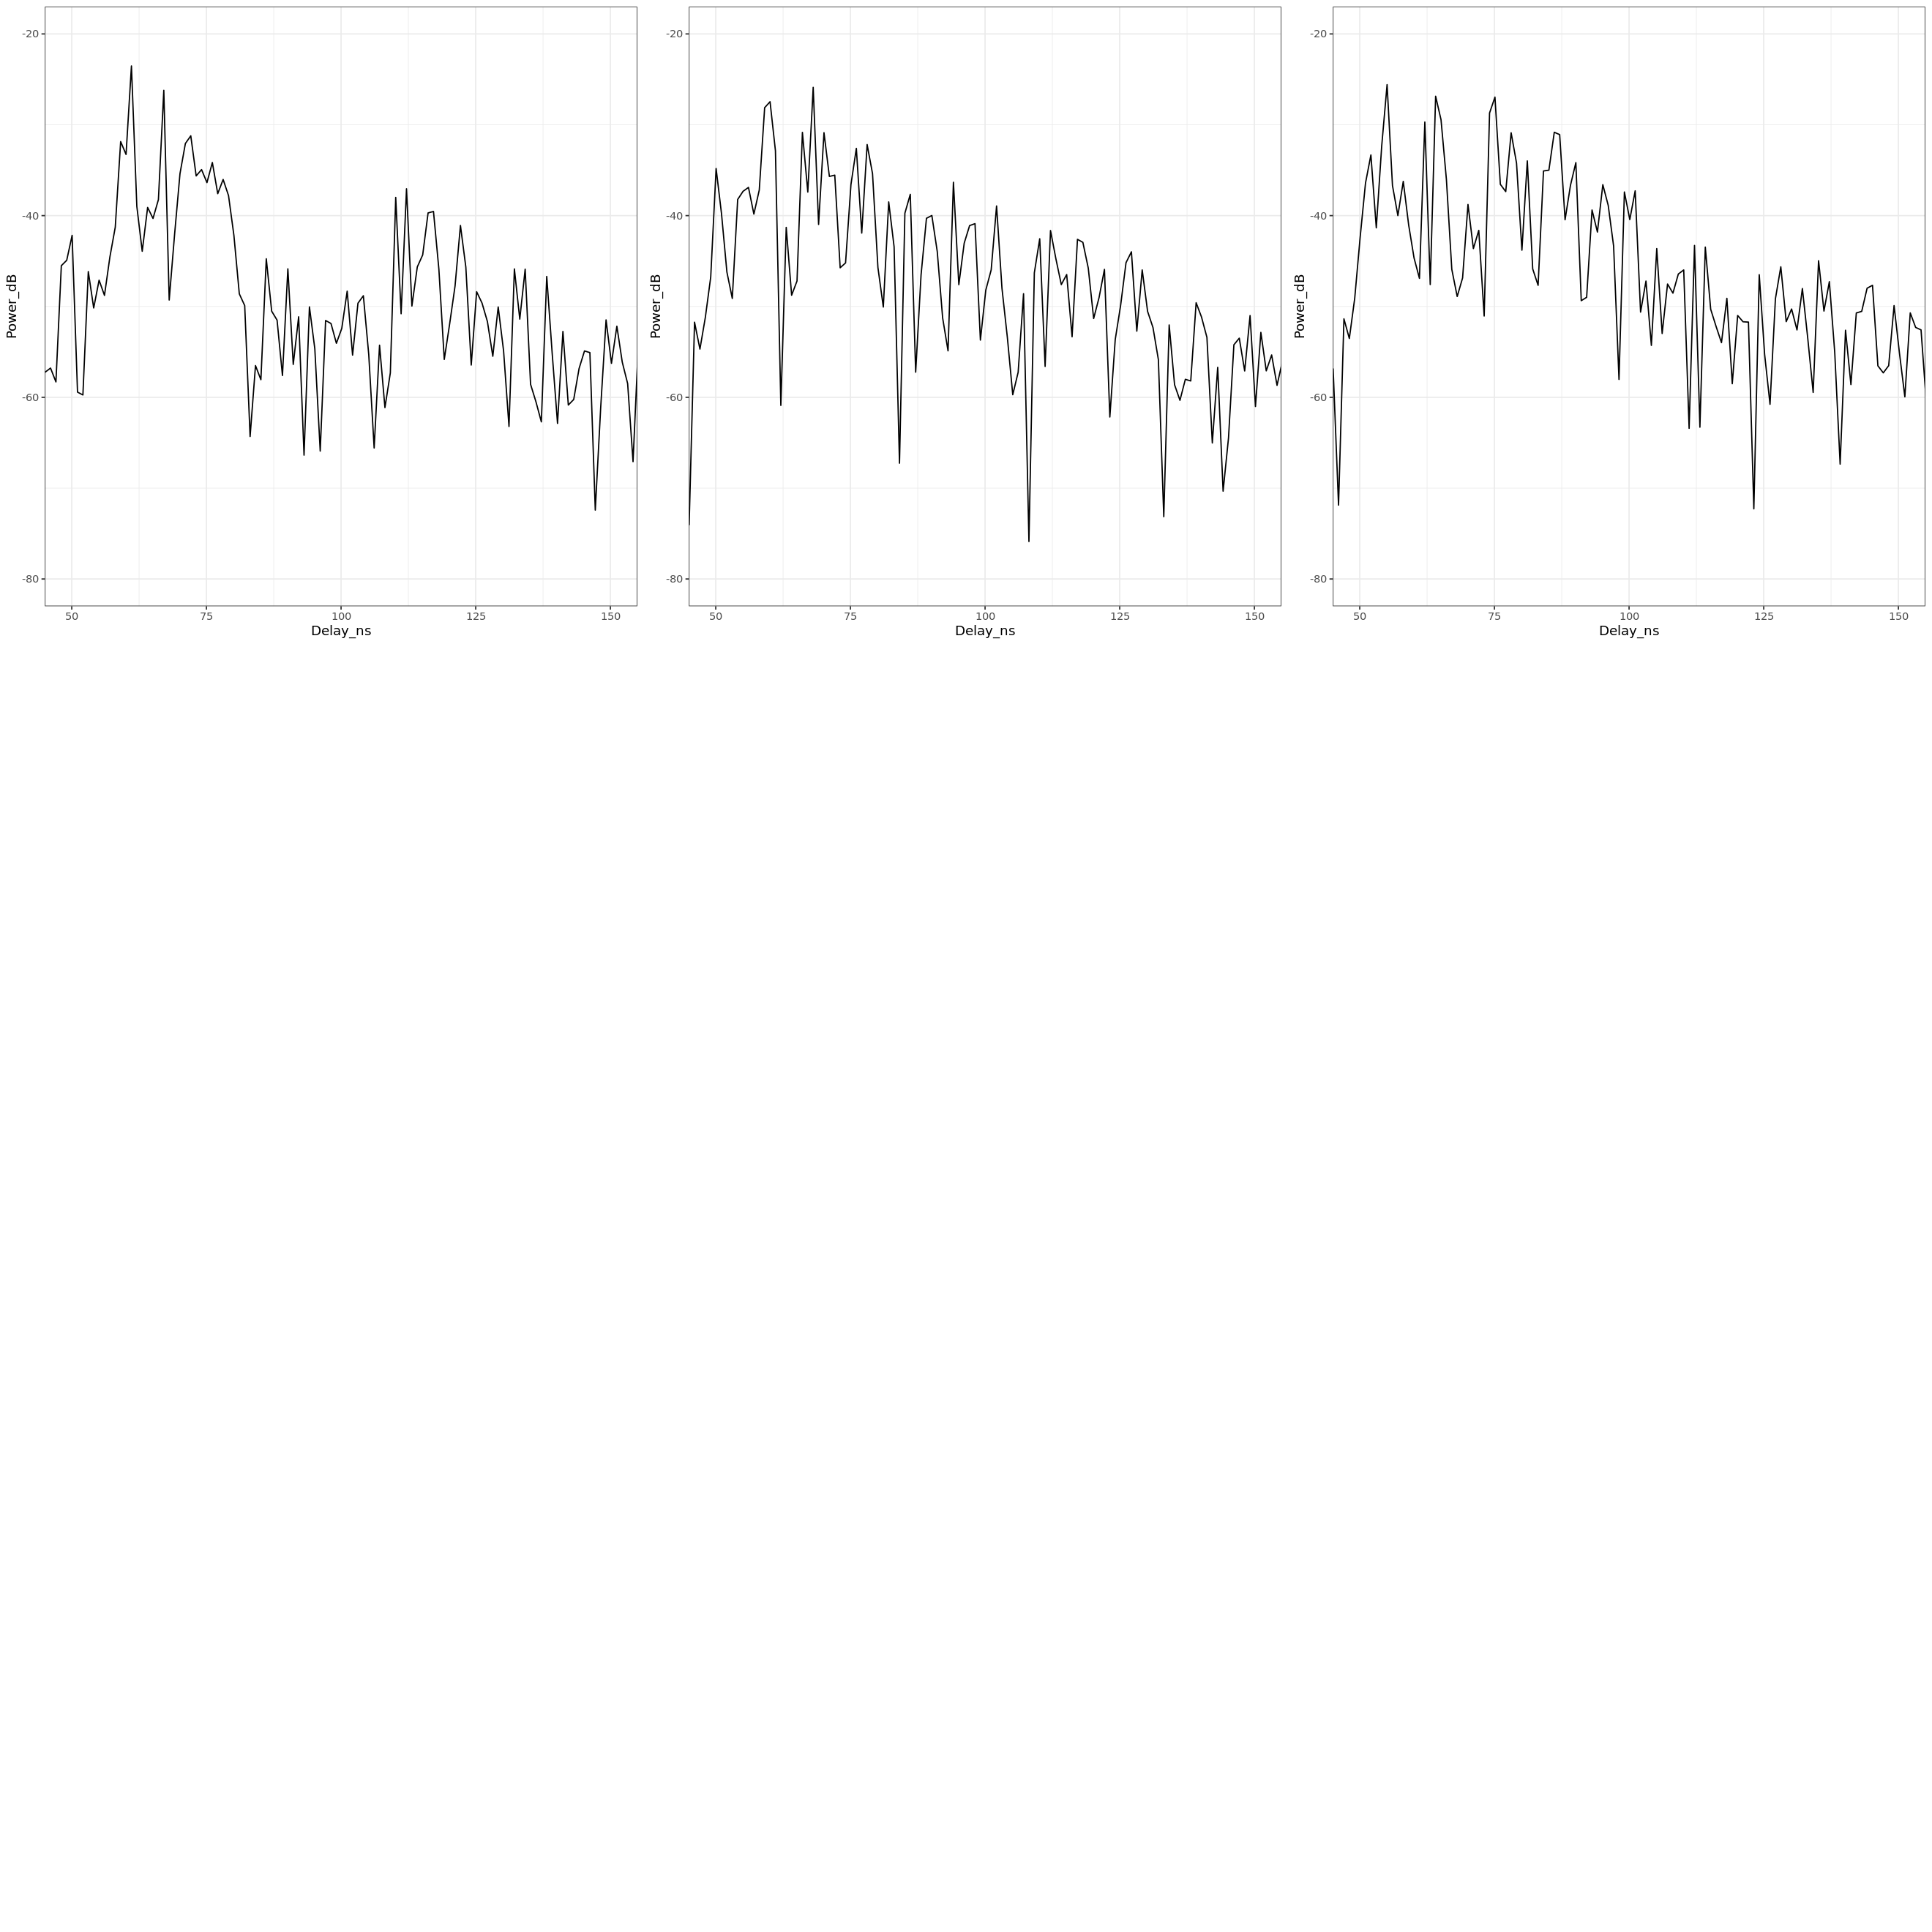

In [87]:
options(repr.plot.width = 22, 
        repr.plot.height = 22)
win = c(50, 150)
plots <- lapply(list(y_meas, y_wei[[1]], y_wei[[2]]),
                function(ys)
    power_delay_plot( ys, xlim = win, dB = T) + 
        ylim(-80, -20)
)
grid.arrange(plots[[1]], 
             plots[[2]], 
             plots[[3]], 
             ncol = 3, nrow = 3)


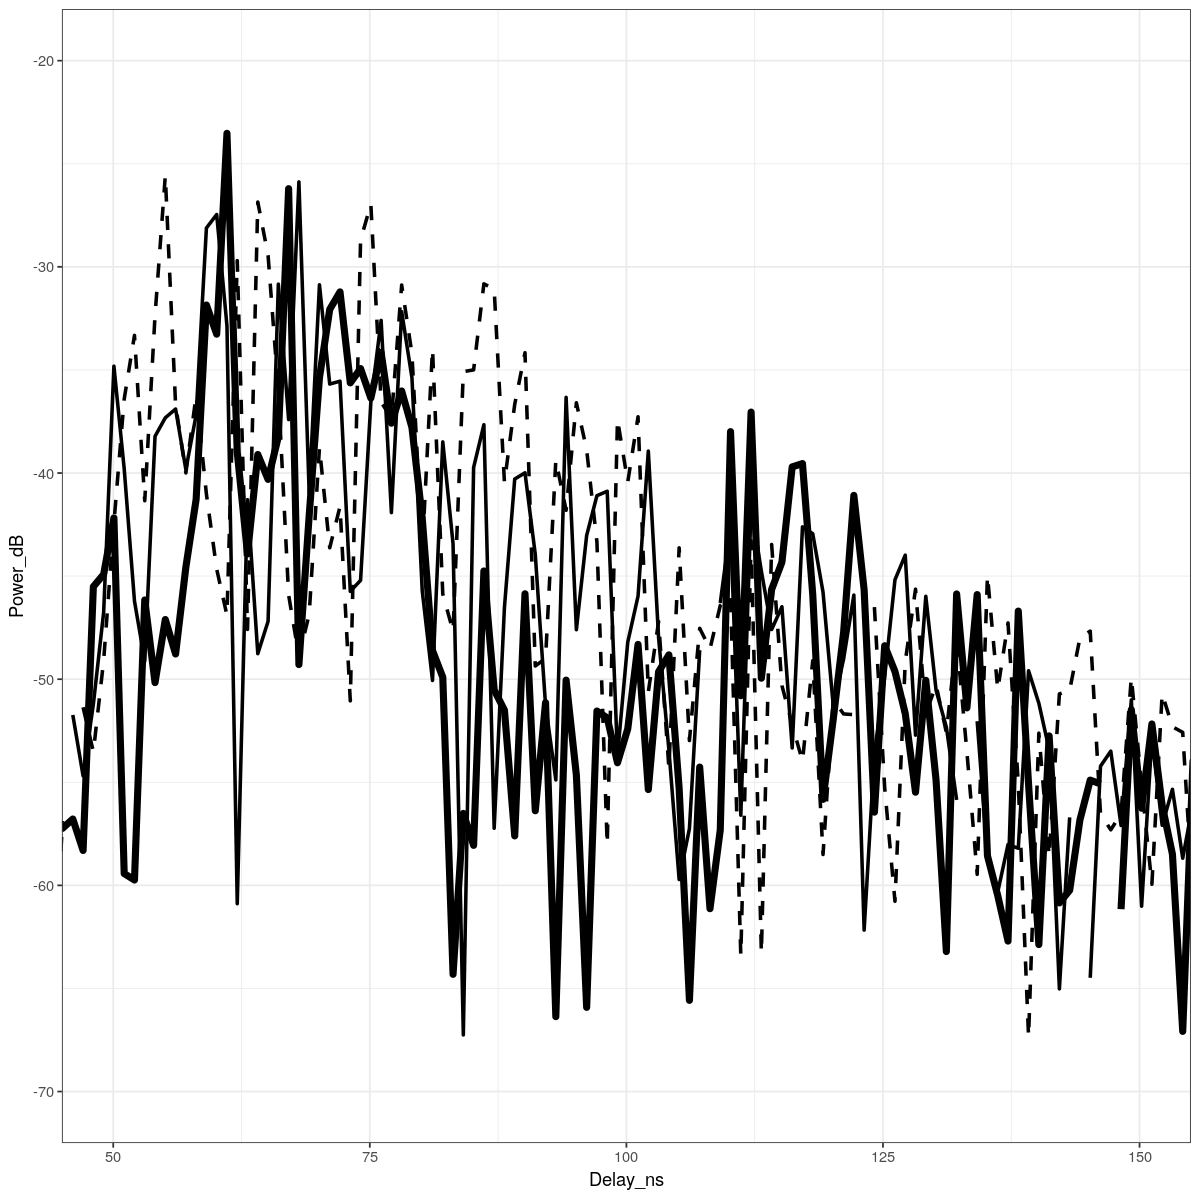

In [56]:
options(repr.plot.width = 10, 
        repr.plot.height = 10)
win = c(50, 150)

    power_delay_plot( list(y_meas, y_wei[[1]], y_wei[[2]]), xlim = win, dB = T) + 
        ylim(-70, -20)